## <h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import datetime as dt

import distance
import time
import csv
import math
import re
import os
import gc
import sys 
import sqlite3

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS

from os import path
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sqlalchemy import create_engine # database connection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
#Reading the csv file
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
#To get a glimpse of how the data looks like
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
#To get a basic overview of the dataset :- presence of any nulls as well as the memory consumed.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>

- Number of duplicate(smilar) and non-duplicate(non similar) questions

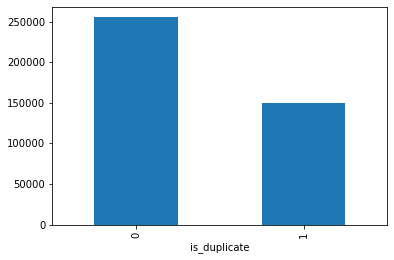

In [5]:
#EDA on Number of Duplicate & Non-Duplicate Questions
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
#Distribution of Number of Duplicate & Non Duplicate Questions
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of Unique Questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



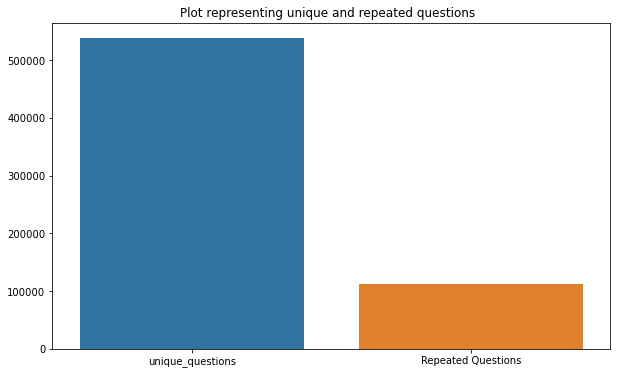

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#Checking whether there are any repeated pair of questions or not

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



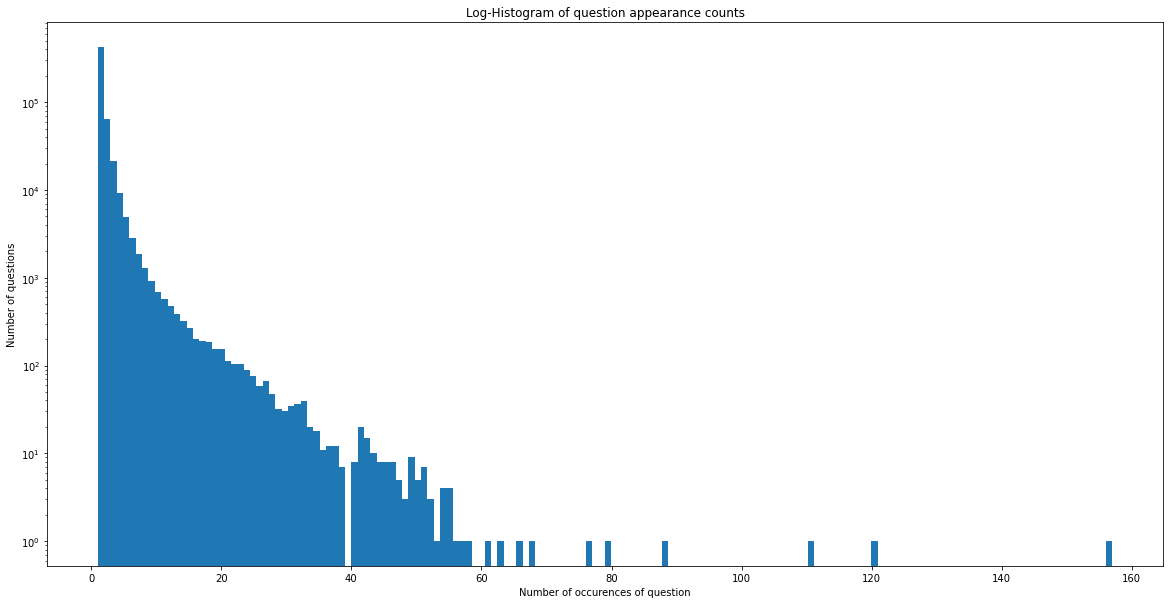

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [14]:
#Overview of the Dataset after filling all the nulls with ' '
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [15]:
#Making a copy of the dataset obtained so far and storing the same in loaded_df
data = df.copy()
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [16]:
#Stratify tries to ensure that when you are splitting the data into Train and Test the proportion of our class 
#labels across the obtained datasets remain the same. 

y_true = data['is_duplicate']

#Splitting the dataset into Train and Test :- (X_train and y_train are temporary datasets)
X_train, X_test_org, y_train, y_test_org = train_test_split(data,y_true, test_size=0.30, random_state=42,stratify=y_true)

#Splitting the dataset into Train and CV :- (X_train and y_train are temporary datasets & X_train2 and y_train2
#are our final Train data components)
X_train2_org, X_cv_org, y_train2_org, y_cv_org = train_test_split(X_train,y_train,test_size=0.20, random_state=42,stratify=y_train)

In [17]:
#Shape of each of the Datasets obtained

print("Number of data points in train data :",X_train2_org.shape)
print("Number of data points in CV data :",X_cv_org.shape)
print("Number of data points in test data :",X_test_org.shape)

Number of data points in train data : (226402, 6)
Number of data points in CV data : (56601, 6)
Number of data points in test data : (121287, 6)


In [18]:
#Checking the class label distribution across both the Train as well as the Test Datasets 

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train2_org)
train_len = len(y_train2_org)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test_org)
test_len = len(y_test_org)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308027314246341 Class 1:  0.36919726857536594
---------- Distribution of output variable in test data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [19]:
#Adding all the basic featurizations to the Dataframe
def basic_feat_addition_1(dataset):
    dataset['word_Common'] = dataset.apply(normalized_word_Common, axis=1)
    dataset['word_Total'] = dataset.apply(normalized_word_Total, axis=1)
    dataset['word_share'] = dataset.apply(normalized_word_share, axis=1)
    return dataset

def basic_feat_addition_2(dataset):
    dataset_name = str(dataset)
    if "train" in dataset_name:
        if os.path.isfile('df_fe_without_preprocessing_train.csv'):
            dataset = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    elif "test" in dataset_name:
        if os.path.isfile('df_fe_without_preprocessing_test.csv'):
            dataset = pd.read_csv("df_fe_without_preprocessing_test.csv",encoding='latin-1')
    elif os.path.isfile('df_fe_without_preprocessing_cv.csv'):
            dataset = pd.read_csv("df_fe_without_preprocessing_cv.csv",encoding='latin-1')
    else:
        dataset['freq_qid1'] = dataset.groupby('qid1')['qid1'].transform('count') 
        dataset['freq_qid2'] = dataset.groupby('qid2')['qid2'].transform('count')
        dataset['q1len'] = dataset['question1'].str.len() 
        dataset['q2len'] = dataset['question2'].str.len()
        dataset['q1_n_words'] = dataset['question1'].apply(lambda row: len(row.split(" ")))
        dataset['q2_n_words'] = dataset['question2'].apply(lambda row: len(row.split(" ")))
        dataset['freq_q1+q2'] = dataset['freq_qid1']+ dataset['freq_qid2']
        dataset['freq_q1-q2'] = abs(dataset['freq_qid1']-dataset['freq_qid2'])
    return dataset


def basic_feat_tot(dataset):
    dataset['freq_qid1'] = dataset.groupby('qid1')['qid1'].transform('count') 
    dataset['freq_qid2'] = dataset.groupby('qid2')['qid2'].transform('count')
    dataset['q1len'] = dataset['question1'].str.len() 
    dataset['q2len'] = dataset['question2'].str.len()
    dataset['q1_n_words'] = dataset['question1'].apply(lambda row: len(row.split(" ")))
    dataset['q2_n_words'] = dataset['question2'].apply(lambda row: len(row.split(" ")))
    dataset['freq_q1+q2'] = dataset['freq_qid1']+ dataset['freq_qid2']
    dataset['freq_q1-q2'] = abs(dataset['freq_qid1']-dataset['freq_qid2'])
    return dataset

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
    
    
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
    

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


In [20]:
X_train2_org_2 = X_train2_org.copy()
X_cv_org_2 = X_cv_org.copy()
X_test_org_2 = X_test_org.copy()

X_train2 = X_train2_org.copy()
X_cv = X_cv_org.copy()
X_test = X_test_org.copy()

X_train2.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
25773,25773,48022,48023,Can you tender a one rupee note in such a mann...,If [math]1\circ4=5[/math] and [math]2\circ5=12...,0
290531,290531,70277,129972,Will Donald Trump or Hillary Clinton win the 2...,Who will win the us 2016 presidential election...,1


In [21]:
X_train2_org_2.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
25773,25773,48022,48023,Can you tender a one rupee note in such a mann...,If [math]1\circ4=5[/math] and [math]2\circ5=12...,0
290531,290531,70277,129972,Will Donald Trump or Hillary Clinton win the 2...,Who will win the us 2016 presidential election...,1


In [22]:
basic_fe_df_train = basic_feat_addition_1(X_train2_org_2)
basic_fe_df_train2 = basic_feat_addition_2(basic_fe_df_train)
basic_fe_df_train2.to_csv("df_fe_without_preprocessing_train.csv", index=False)

basic_fe_df_cv1 = basic_feat_addition_1(X_cv_org_2)
basic_fe_df_cv = basic_feat_addition_2(basic_fe_df_cv1)
basic_fe_df_cv.to_csv("df_fe_without_preprocessing_cv.csv", index=False)

basic_fe_df_test1 = basic_feat_addition_1(X_test_org_2)
basic_fe_df_test = basic_feat_addition_2(basic_fe_df_test1)
basic_fe_df_test.to_csv("df_fe_without_preprocessing_test.csv", index=False)

In [23]:
#Making a copy of the Dataframe and storing it in basic_fe_df :- DF with all the Basic Featurizations.
basic_fe_df1 = basic_feat_addition_1(data)
basic_fe_df = basic_feat_tot(basic_fe_df1)
basic_fe_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,word_Common,word_Total,word_share,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10.0,23.0,0.434783,1,1,66,57,14,12,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4.0,20.0,0.200000,4,1,51,88,8,13,5,3


In [24]:
basic_fe_df_train2.shape

(56601, 17)

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [25]:
print ("Minimum length of the questions in question1 : " , min(basic_fe_df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(basic_fe_df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", basic_fe_df[basic_fe_df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", basic_fe_df[basic_fe_df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

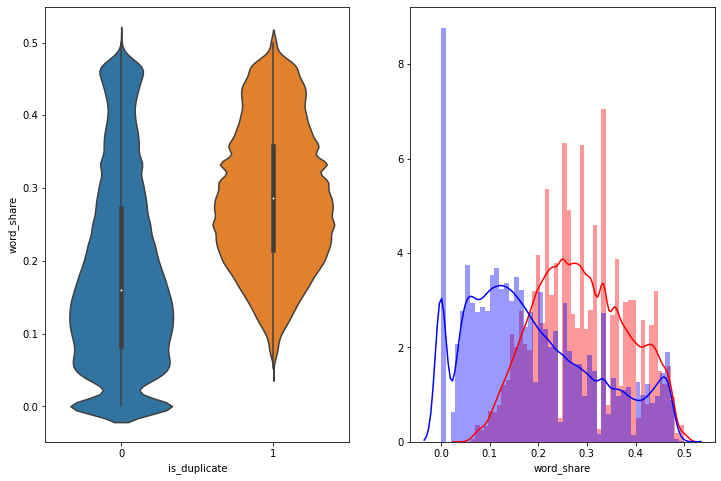

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = basic_fe_df[0:])

plt.subplot(1,2,2)
sns.distplot(basic_fe_df[basic_fe_df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(basic_fe_df[basic_fe_df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> Observations :- </h4>

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar).

<h4> 3.3.1.2 Feature: word_Common </h4>

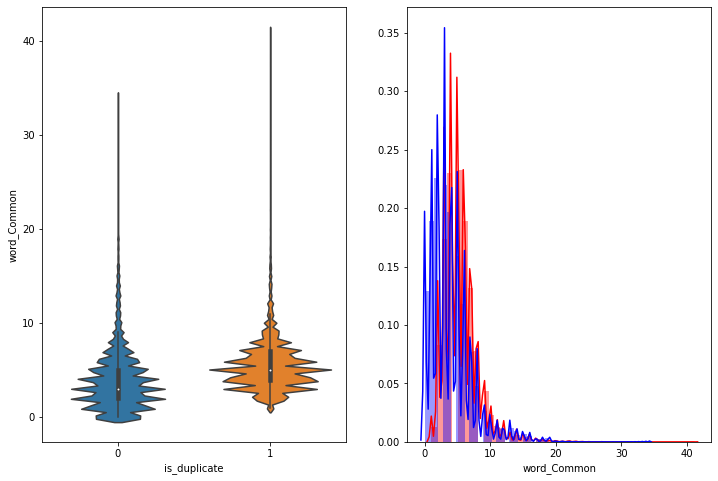

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = basic_fe_df[0:])

plt.subplot(1,2,2)
sns.distplot(basic_fe_df[basic_fe_df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(basic_fe_df[basic_fe_df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> Observations :- </h4>

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping. </p>

### 1.2.1 : EDA: Advanced Feature Extraction.

<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [28]:
import nltk
nltk.download('stopwords')

# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

# Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dhruvnarayanan20/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#Taking a DF Copy : basic_fe_ppro_df consists of all the Basic Featurizations obtained after preprocessing. 
basic_fe_ppro_df = basic_fe_df.copy()
basic_fe_ppro_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,word_Common,word_Total,word_share,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10.0,23.0,0.434783,1,1,66,57,14,12,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4.0,20.0,0.200000,4,1,51,88,8,13,5,3


<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting a sentence by a space. When Tokens are defined, we only define the set of Tokens. The values do not repeat in a set.
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage

http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage

http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage

http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage

http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



Edit Distance :- Ie the addition, deletion or shifting of characters/values in a sentence to make it similar to the
other distance.

In [30]:
#Function to obtain all the Advance Featurizations

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [31]:
if not os.path.isfile('nlp_features_train.csv'):
    adv_fe_df_train = extract_features(X_train2)
    adv_fe_df_train.to_csv("nlp_features_train.csv", index=False)
else:
    adv_fe_df_train = pd.read_csv('nlp_features_train.csv')

if not os.path.isfile('nlp_features_cv.csv'):
    adv_fe_df_cv = extract_features(X_cv)
    adv_fe_df_cv.to_csv("nlp_features_cv.csv", index=False)
else:
    adv_fe_df_cv = pd.read_csv('nlp_features_cv.csv')
    
if not os.path.isfile('nlp_features_test.csv'):
    adv_fe_df_test = extract_features(X_test)
    adv_fe_df_test.to_csv("nlp_features_test.csv", index=False)
else:
    adv_fe_df_test = pd.read_csv('nlp_features_test.csv')

In [32]:
if os.path.isfile('nlp_features_all.csv'):
    adv_fe_df = pd.read_csv("nlp_features_all.csv",encoding='latin-1')
    adv_fe_df.fillna('')
else:
    print("Extracting features for train:")
    adv_fe_df = pd.read_csv("train.csv")
    adv_fe_df = extract_features(adv_fe_df)
    adv_fe_df.to_csv("nlp_features_all.csv", index=False)

#adv_fe_df consists of only the advanced featurizations carried out.
adv_fe_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [33]:
df_duplicate = adv_fe_df[adv_fe_df['is_duplicate'] == 1]
dfp_nonduplicate = adv_fe_df[adv_fe_df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [34]:
# reading the text files and addition as well as removal of the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


Word Cloud for Duplicate Question pairs


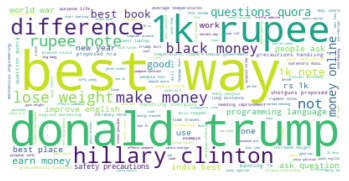

In [35]:
# Word Clouds generated from  duplicate pair question's text :-

wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


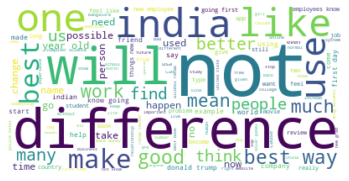

In [36]:
# Word Clouds generated from non duplicate pair question's text :-

wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

The word Best (way) occurs in both of these wordclouds :- fewer times in non dupli questions (smaller font size).

Conclusion :-
* Some words occur more often in Class 1 as compared to class 0 and vice-versa.
* This means that simple ideas like BOW,TFIDF etc features should be useful.

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

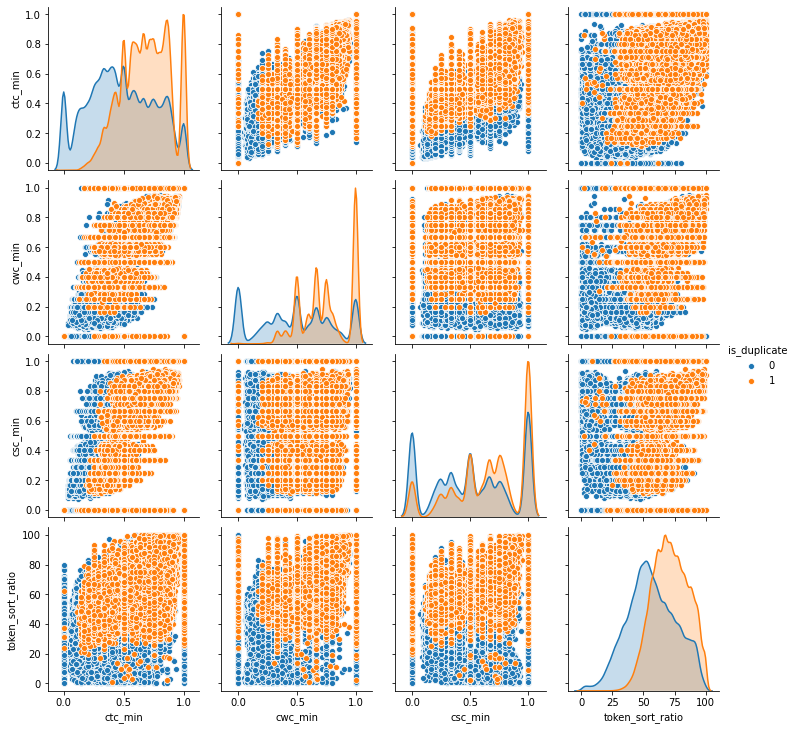

In [37]:
n = adv_fe_df.shape[0]
sns.pairplot(adv_fe_df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h4> Observations :- </h4>

* You see bigger histogram plots for class 1 when ctc_min is larger. 
* Pair Plot between csc_min and ctc_min :- There is some overlap but you also have some distinct regions where you only find the Blue Points and where you only find the Orange points. This means that there is partial separability(if not full separability) between these 2 classes that you have.

* Similarly, Pair Plot between token_sort_ratio abd csc_min :- Again you see partial separation between the orange and blue regions. This shows that there is value in each of the features that we generated individually. 

* From curve :- You will notice that you find more class 1 points when your token_sort_ratio is higher.
  This means that each of your features are useful from a univariate as well as a bivariate sense.


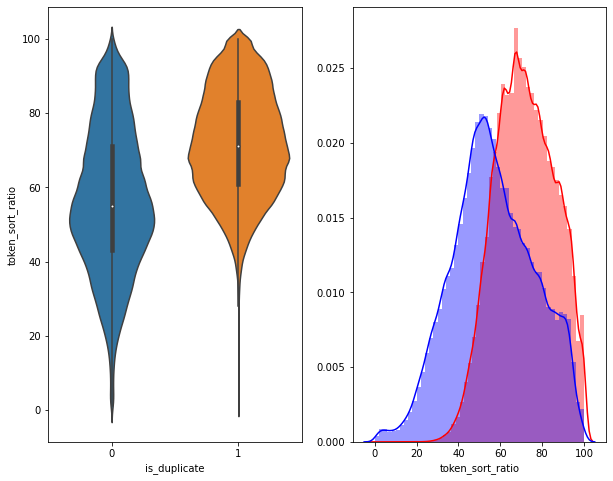

In [38]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = adv_fe_df[0:] , )

plt.subplot(1,2,2)
sns.distplot(adv_fe_df[adv_fe_df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(adv_fe_df[adv_fe_df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> Observations :- </h4>

* If you take token_sort_ratio and you plot the PDF for token_sort_ratio across the 2 classes, where Blue colour is for class 0 and Orange Colour is for class 1. 
* You notice that both of these curves have some overlap as shown, but typically you see that class 1 points tend to have a larger value of token_sort_ratio than class 0 points. 
* On the left you have a box plot and a violin plot for token_sort_ratio, and the fact that these 2 Violins do not fully overlap shows that our token_sort_ratio is an interesting feature for our Classification Task. 
* Again, when you draw the same plots for the fuzz_ratio feature you see an overlap region, but you also tend to find more points belonging to class 1 have a larger value of fuzz_ratio than the points belonging to class 0.
* Also you will see that the Box plots on the left as well as the Violin plots are not completely overlapping.
  This means that even our fuzz_ratio feature is useful in determining the class label.

<h3>3.5.2 Visualization </h3>

We have a lot of features that we designed and here we have only carried out Univariate Analysis and Bivariate Analysis. But what will happen if from the total 15 Advanced Features that we designed we are able to visualize our data in 15-D space using techniques like TSNE that uses dimensionality reduction. :- to see if our classes can be separated in the 15-D space or not. We will see this below.

In [39]:
# Using TSNE for Dimensionality reduction for 15 Features(Generated after cleaning the data) to 3 dimensions

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = adv_fe_df[0:5000]
#We have sampled a subset of points because TSNE takes a lot of time to run.

X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 
                                                 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 
                                                 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  
                                                 'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [40]:
#To construct the TSNE Visualizations on the Dataset for various values of Perplexity.

def construct_tsne(data,perplexity):
    
    tsne2d = TSNE(n_components=2, init='random',random_state=101,method='barnes_hut',n_iter=1000,
                  perplexity=perplexity,verbose=2,angle=0.5).fit_transform(data)

    tsne_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

    # draw the plot in appropriate place in the grid
    sns.lmplot(data=tsne_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
    plt.title("perplexity : {} and max_iter : {}".format(perplexity, 1000))
    plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.070513
[t-SNE] Computed conditional probabilities in 0.069s
[t-SNE] Iteration 50: error = 107.6480942, gradient norm = 0.0612190 (50 iterations in 0.568s)
[t-SNE] Iteration 100: error = 89.5645828, gradient norm = 0.0257559 (50 iterations in 0.411s)
[t-SNE] Iteration 150: error = 85.0621567, gradient norm = 0.0180439 (50 iterations in 0.386s)
[t-SNE] Iteration 200: error = 82.8262787, gradient norm = 0.0109525 (50 iterations in 0.392s)
[t-SNE] Iteration 250: error = 81.4936905, gradient norm = 0.011605

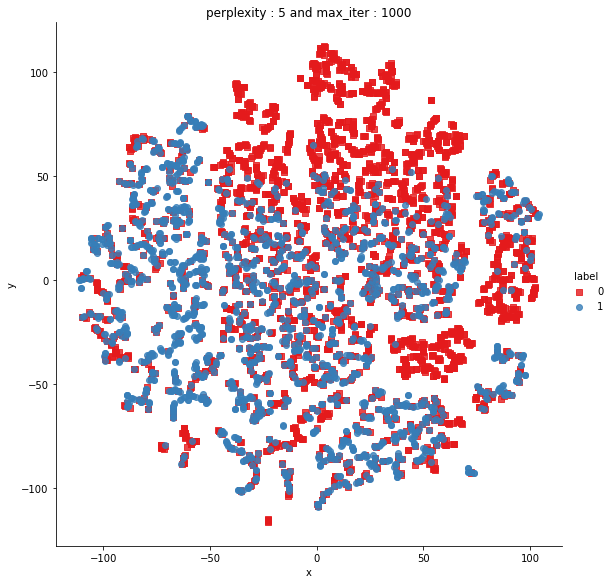

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.320s
[t-SNE] Iteration 50: error = 81.3443146, gradient norm = 0.0466835 (50 iterations in 0.531s)
[t-SNE] Iteration 100: error = 70.6514740, gradient norm = 0.0087385 (50 iterations in 0.478s)
[t-SNE] Iteration 150: error = 68.9514694, gradient norm = 0.0055224 (50 iterations in 0.470s)
[t-SNE] Iteration 200: error = 68.1305695, gradient norm = 0.0044136 (50 iterations in 0.481s)
[t-SNE] Iteration 250: error = 67.6242371, gradient norm = 0.0040027

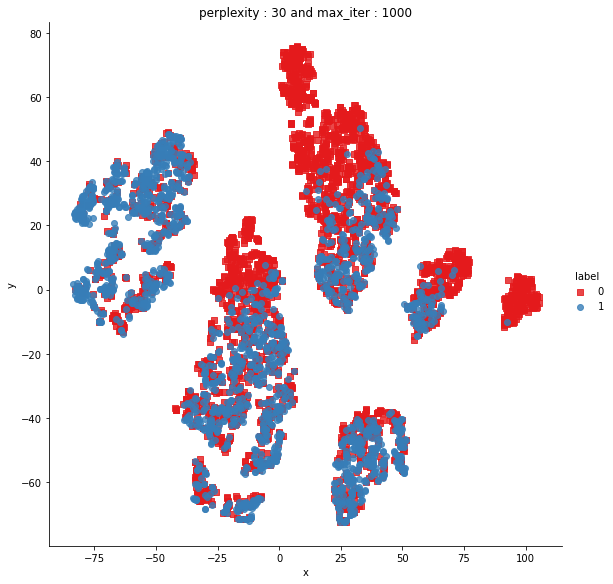

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.142135
[t-SNE] Computed conditional probabilities in 0.425s
[t-SNE] Iteration 50: error = 77.6983795, gradient norm = 0.0412668 (50 iterations in 0.547s)
[t-SNE] Iteration 100: error = 67.8906631, gradient norm = 0.0100046 (50 iterations in 0.513s)
[t-SNE] Iteration 150: error = 66.4162064, gradient norm = 0.0052745 (50 iterations in 0.493s)
[t-SNE] Iteration 200: error = 65.7189407, gradient norm = 0.0040927 (50 iterations in 0.490s)
[t-SNE] Iteration 250: error = 65.3196411, gradient norm = 0.002818

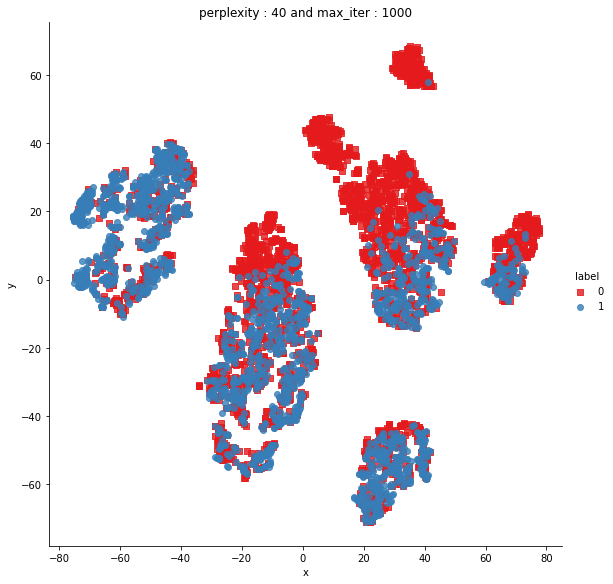

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.475s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.152133
[t-SNE] Computed conditional probabilities in 0.519s
[t-SNE] Iteration 50: error = 74.9651413, gradient norm = 0.0364561 (50 iterations in 0.578s)
[t-SNE] Iteration 100: error = 65.7224197, gradient norm = 0.0082924 (50 iterations in 0.528s)
[t-SNE] Iteration 150: error = 64.3833389, gradient norm = 0.0043756 (50 iterations in 0.530s)
[t-SNE] Iteration 200: error = 63.7789650, gradient norm = 0.0034543 (50 iterations in 0.525s)
[t-SNE] Iteration 250: error = 63.3972702, gradient norm = 0.002571

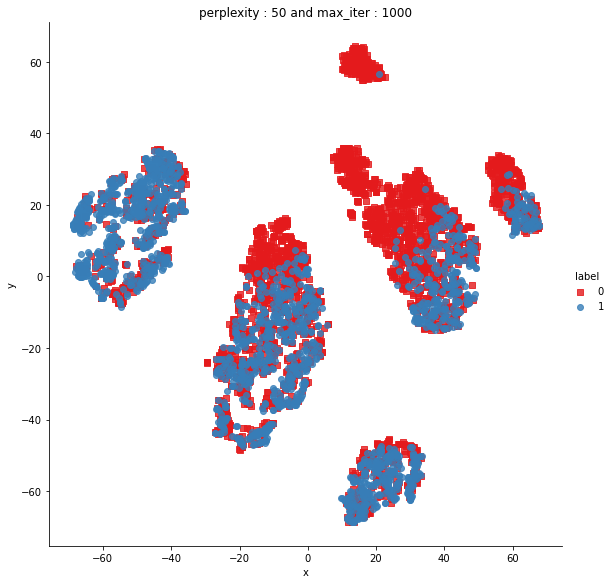

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.723s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.190385
[t-SNE] Computed conditional probabilities in 1.014s
[t-SNE] Iteration 50: error = 66.8886871, gradient norm = 0.0328420 (50 iterations in 0.737s)
[t-SNE] Iteration 100: error = 59.4364014, gradient norm = 0.0071066 (50 iterations in 0.675s)
[t-SNE] Iteration 150: error = 58.2296257, gradient norm = 0.0042483 (50 iterations in 0.664s)
[t-SNE] Iteration 200: error = 57.7560997, gradient norm = 0.0028676 (50 iterations in 0.664s)
[t-SNE] Iteration 250: error = 57.4784775, gradient norm = 0.002352

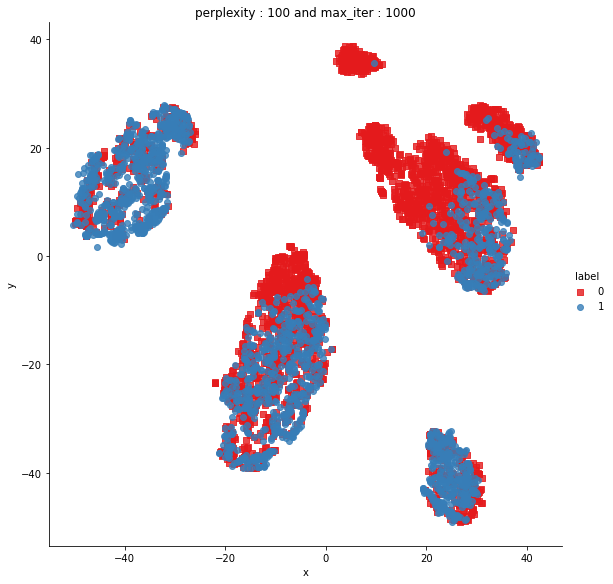

[t-SNE] Computing 901 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 1.592s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.289956
[t-SNE] Computed conditional probabilities in 2.916s
[t-SNE] Iteration 50: error = 55.2824059, gradient norm = 0.0403259 (50 iterations in 1.801s)
[t-SNE] Iteration 100: error = 49.4435616, gradient norm = 0.0052430 (50 iterations in 1.675s)
[t-SNE] Iteration 150: error = 48.7631836, gradient norm = 0.0023730 (50 iterations in 1.657s)
[t-SNE] Iteration 200: error = 48.4903603, gradient norm = 0.0015724 (50 iterations in 1.657s)
[t-SNE] Iteration 250: error = 48.3438950, gradient norm = 0.001203

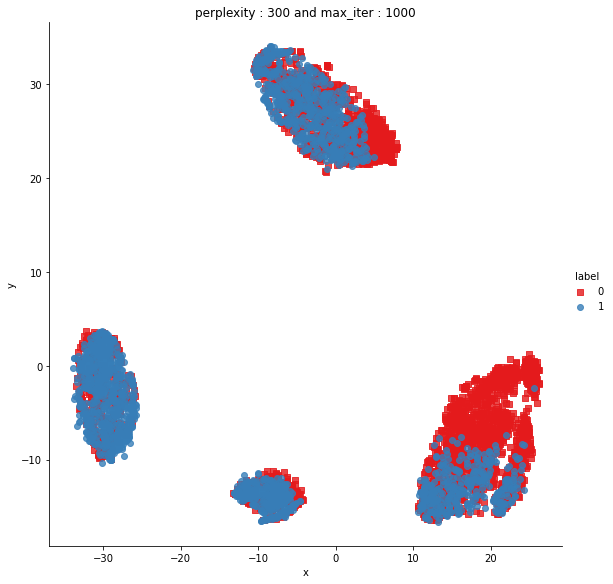

In [41]:
#Trying for various values of perplexity
perplexity = [5,30,40,50,100,300]
for p in perplexity:
    construct_tsne(X,p)

<h4> Observations :- </h4>


* You can notice that here, a lot of Class 0 points are clearly separable from your Class 1 Points, although there are also regions where we can see a considerable amount of overlapping.
* This plot gives us a hint that in the 15 Dimensional Feature set that we have designed there is value because you are able to separate class 0 from class 1 :- Not perfectly, but in a reasonable number of cases.
* Also we can note that our classes are slightly more separatable as our perplexity value increases.


<h2> 3.6 Featurizing Text Data with TFIDF Weighted Word-Vectors </h2>

1. Previously, when we were doing analysis on the Data, we realized that there is value in the words that are present in your questions :- Because we noticed that some words occur more often in Class 1 Question Pairs whereas some words occur more often in Class 0 Question Pairs.
2. We will try to leverage this information and build featurization using both TFIDF and word-vectors (For word vectors we have seen W2V). :- In this technique you compute the Vector Representation for each of your words in the Corpus, and instead of just taking the average, we take a Weighted Average basis the TFIDF values obtained for each word.
  {TFIDF Weighted W2V is a better option as compared to Avg W2V)
3. There is a very similar concept to W2Vec called GLOVE (It also does the same thing), but in a different manner.

4. GLOVE means Global Vector ie. given any word both of these techniques return a vector, such that the semantic relationship between words is preserved in this Vector Representation. For a Black Box thinker, both of these techniques serve the same purpose :- {Preserving the Semantic Relationship}.


In [40]:
# avoid decoding problems

X_train2_org['question1'] = X_train2_org['question1'].apply(lambda x: str(x))
X_train2_org['question2'] = X_train2_org['question2'].apply(lambda x: str(x))

X_cv_org['question1'] = X_cv_org['question1'].apply(lambda x: str(x))
X_cv_org['question2'] = X_cv_org['question2'].apply(lambda x: str(x))

X_test_org['question1'] = X_test_org['question1'].apply(lambda x: str(x))
X_test_org['question2'] = X_test_org['question2'].apply(lambda x: str(x))

In [41]:
X_train2_org.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
25773,25773,48022,48023,Can you tender a one rupee note in such a mann...,If [math]1\circ4=5[/math] and [math]2\circ5=12...,0
290531,290531,70277,129972,Will Donald Trump or Hillary Clinton win the 2...,Who will win the us 2016 presidential election...,1


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train2_org['question1']) + list(X_train2_org['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [43]:
X_cv_org.shape

(56601, 6)

<h4> Note :- </h4>

* After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
* Here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
* For the GLOVE technique defined above you only need to use a library called spacy. The file that you load is trained on the Wikipedia Dataset, and therefore is very strong in terms of Word Semantics.
* Except the fact that we are using GLOVE instead of Word2Vec there is no other difference in our approach :- It is a slightly different algorithm. Note that the manner in which you obtain the vector is also the same as in Word2Vec.
* You can compute the TFIDF values using the TFIDF Vectorizer (which is present in scikit-learn internally). 

<h3>3.6.1 Obtaining the Word2Vec Representations :- </h3>

In [44]:
# en_vectors_web_lg, which includes over 1 million unique vectors.

#Function that provides the TFIDF W2V Representation for the dataset and question provided
def tfidf_feat(dataset,question,column_name):
    
    import spacy,en_core_web_sm
    nlp = en_core_web_sm.load()
    
    question = str(question)
    vector = []
    
    for qu in tqdm(list(dataset[question])):
        # https://github.com/noamraph/tqdm
        # tqdm is used to print the progress bar
        doc = nlp(qu) 
        
        # 96 is the Dimensionality of the Vectors obtained after latest update. 
        mean_vec = np.zeros([len(doc),96])
    
        for word in doc:
    # word2vec
            vec = word.vector
    # fetch df score
            try:
                idf = word2tfidf[str(word)]
            except:
                idf = 0
        # compute final vec
            mean_vec += vec * idf
    
        mean_vec = mean_vec.mean(axis=0)
        vector.append(mean_vec)
    dataset[column_name] = list(vector)
    return dataset

In [54]:
#Obtaining the TFIDF W2V Representation for each of our datasets
X_train2_tfidf_w2v = tfidf_feat(X_train2_org,'question1','q1_feats_m')
X_train2_tfidf_w2v = tfidf_feat(X_train2_org,'question2','q2_feats_m')

X_cv_tfidf_w2v = tfidf_feat(X_cv_org,'question1','q1_feats_m')
X_cv_tfidf_w2v = tfidf_feat(X_cv_org,'question2','q2_feats_m')

X_test_tfidf_w2v = tfidf_feat(X_test_org,'question1','q1_feats_m')
X_test_tfidf_w2v = tfidf_feat(X_test_org,'question2','q2_feats_m')

100%|██████████| 121287/121287 [19:38<00:00, 102.92it/s]


In [45]:
#Pickling the Dataframe obtained (with Word2Vec Representation for each of the questions) for future use:-
if not os.path.isfile('pickles/X_train2_tfidf_w2v'):
    X_train2_tfidf_w2v.to_pickle('pickles/X_train2_tfidf_w2v')
X_train2_tfidf_w2v = pd.read_pickle('pickles/X_train2_tfidf_w2v')

if not os.path.isfile('pickles/X_cv_tfidf_w2v'):
    X_cv_tfidf_w2v.to_pickle('pickles/X_cv_tfidf_w2v')
X_cv_tfidf_w2v = pd.read_pickle('pickles/X_cv_tfidf_w2v')

if not os.path.isfile('pickles/X_test_tfidf_w2v'):
    X_test_tfidf_w2v.to_pickle('pickles/X_test_tfidf_w2v')
X_test_tfidf_w2v = pd.read_pickle('pickles/X_test_tfidf_w2v')

In [46]:
advance_feat_df_train = adv_fe_df_train.drop(['qid1','qid2','question1','question2'],axis=1)
basic_feat_df_train = basic_fe_df_train2.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
w2v_df_train = X_train2_tfidf_w2v.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
w2v_q1_train = pd.DataFrame(X_train2_tfidf_w2v.q1_feats_m.values.tolist(), index= w2v_df_train.index)
w2v_q2_train = pd.DataFrame(X_train2_tfidf_w2v.q2_feats_m.values.tolist(), index= w2v_df_train.index)


advance_feat_df_cv = adv_fe_df_cv.drop(['qid1','qid2','question1','question2'],axis=1)
basic_feat_df_cv = basic_fe_df_cv.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
w2v_df_cv = X_cv_tfidf_w2v.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
w2v_q1_cv = pd.DataFrame(X_cv_tfidf_w2v.q1_feats_m.values.tolist(), index= w2v_df_cv.index)
w2v_q2_cv = pd.DataFrame(X_cv_tfidf_w2v.q2_feats_m.values.tolist(), index= w2v_df_cv.index)


advance_feat_df_test = adv_fe_df_test.drop(['qid1','qid2','question1','question2'],axis=1)
basic_feat_df_test = basic_fe_df_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
w2v_df_test = X_test_tfidf_w2v.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
w2v_q1_test = pd.DataFrame(X_test_tfidf_w2v.q1_feats_m.values.tolist(), index= w2v_df_test.index)
w2v_q2_test = pd.DataFrame(X_test_tfidf_w2v.q2_feats_m.values.tolist(), index= w2v_df_test.index)


In [47]:
#Pickling each of the dataframes obtained for future use. 

if not os.path.isfile('pickles/advance_feat_df_train'):
    advance_feat_df_train.to_pickle('pickles/advance_feat_df_train')
    
if not os.path.isfile('pickles/basic_feat_df_train'):
    basic_feat_df_train.to_pickle('pickles/basic_feat_df_train')
    
if not os.path.isfile('pickles/w2v_df_train'):
    w2v_df_train.to_pickle('pickles/w2v_df_train')
    
if not os.path.isfile('pickles/w2v_q1_train'):
    w2v_q1_train.to_pickle('pickles/w2v_q1_train')
    
if not os.path.isfile('pickles/w2v_q2_train'):
    w2v_q2_train.to_pickle('pickles/w2v_q2_train')
    
advance_feat_df_train = pd.read_pickle('pickles/advance_feat_df_train')
basic_feat_df_train = pd.read_pickle('pickles/basic_feat_df_train')
w2v_df_train = pd.read_pickle('pickles/w2v_df_train')
w2v_q1_train = pd.read_pickle('pickles/w2v_q1_train')
w2v_q2_train = pd.read_pickle('pickles/w2v_q2_train')

#-----------------------------------------------------------------------
#Related to CV Dataset

if not os.path.isfile('pickles/advance_feat_df_cv'):
    advance_feat_df_cv.to_pickle('pickles/advance_feat_df_cv')
    
if not os.path.isfile('pickles/basic_feat_df_cv'):
    basic_feat_df_cv.to_pickle('pickles/basic_feat_df_cv')
    
if not os.path.isfile('pickles/w2v_df_cv'):
    w2v_df_cv.to_pickle('pickles/w2v_df_cv')
    
if not os.path.isfile('pickles/w2v_q1_cv'):
    w2v_q1_cv.to_pickle('pickles/w2v_q1_cv')
    
if not os.path.isfile('pickles/w2v_q2_cv'):
    w2v_q2_cv.to_pickle('pickles/w2v_q2_cv')
    
advance_feat_df_cv = pd.read_pickle('pickles/advance_feat_df_cv')
basic_feat_df_cv = pd.read_pickle('pickles/basic_feat_df_cv')
w2v_df_cv = pd.read_pickle('pickles/w2v_df_cv')
w2v_q1_cv = pd.read_pickle('pickles/w2v_q1_cv')
w2v_q2_cv = pd.read_pickle('pickles/w2v_q2_cv')


#-----------------------------------------------------------------------
#Related to Test Dataset

if not os.path.isfile('pickles/advance_feat_df_test'):
    advance_feat_df_test.to_pickle('pickles/advance_feat_df_test')
    
if not os.path.isfile('pickles/basic_feat_df_test'):
    basic_feat_df_test.to_pickle('pickles/basic_feat_df_test')
    
if not os.path.isfile('pickles/w2v_df_test'):
    w2v_df_test.to_pickle('pickles/w2v_df_test')
    
if not os.path.isfile('pickles/w2v_q1_test'):
    w2v_q1_test.to_pickle('pickles/w2v_q1_test')
    
if not os.path.isfile('pickles/w2v_q2_test'):
    w2v_q2_test.to_pickle('pickles/w2v_q2_test')
    
advance_feat_df_test = pd.read_pickle('pickles/advance_feat_df_test')
basic_feat_df_test = pd.read_pickle('pickles/basic_feat_df_test')
w2v_df_test = pd.read_pickle('pickles/w2v_df_test')
w2v_q1_test = pd.read_pickle('pickles/w2v_q1_test')
w2v_q2_test = pd.read_pickle('pickles/w2v_q2_test')

In [48]:
# dataframe of nlp features
advance_feat_df_train.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
25773,25773,0,0.076922,0.076922,0.000000,0.000000,0.038461,0.037037,0.0,0.0,1.0,26.5,25,26,21,20,0.032520
290531,290531,1,0.499994,0.444440,0.666644,0.333328,0.499996,0.428568,0.0,0.0,2.0,13.0,66,62,50,53,0.289474


In [49]:
basic_feat_df_train.head(2)

,id,word_Common,word_Total,word_share,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2
25773,25773,0.0,35.0,0.000000,1,3,125,122,27,11,4,2
290531,290531,6.0,26.0,0.230769,12,8,75,82,12,14,20,4


In [50]:
# Question 1 tfidf weighted word2vec
w2v_q1_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
25773,-135.580929,-228.455892,-272.179381,-187.741244,117.350810,185.197398,44.047597,35.126765,26.690524,-135.475826,...,-116.746518,176.048055,55.057662,177.698975,29.394574,39.854695,82.171957,-222.836601,-111.245000,-63.112750
290531,-133.231581,31.255562,-105.917761,-134.494729,-60.652583,39.701170,-80.497113,-17.546641,108.681793,-68.587670,...,-72.515683,82.461631,40.790670,98.121342,-78.402017,113.248666,56.355392,-160.927166,-16.461694,64.770676


In [51]:
# Question 2 tfidf weighted word2vec
w2v_q2_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
25773,-26.501241,13.671204,-84.894108,-69.003623,26.044927,18.304493,86.425381,34.596496,41.085975,-53.210536,...,-65.742843,56.126639,-67.518318,17.976613,-31.035441,-1.509603,1.625837,-9.427700,-12.695104,22.369608
290531,-84.239921,-30.185805,-53.714219,-74.577944,39.240181,12.006822,-44.817155,27.893974,-6.182345,-109.092890,...,-2.404415,114.571082,46.371489,22.800800,-22.992144,18.437792,62.815349,-191.606756,-9.625476,1.762662


In [52]:
print("Number of features in nlp dataframe :", advance_feat_df_train.shape[1])
print("Number of features in preprocessed dataframe :", basic_feat_df_train.shape[1])
print("Number of features in question1 w2v  dataframe :", w2v_q1_train.shape[1])
print("Number of features in question2 w2v  dataframe :", w2v_q2_train.shape[1])
print("Number of features in final dataframe  :", advance_feat_df_train.shape[1]+basic_feat_df_train.shape[1]+
                                                  w2v_q1_train.shape[1]+w2v_q2_train.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


<h4> Note :- </h4>

The way that we are operating here is as follows :-

* We have the initial 17 Advance Features as well as your 12 Simple Features. In addition to both of them we obtain TFIDF Weighted Vectors (or GLOVE Vectors) for Question 1 and we get a TFIDF Weighted Vector (GLOVE Vector) for Question 2 as well. Total of this becomes your full feature vector.
* There are a total of 4 Parts to your Full Feature Vector :

                        Simple Features + Advance Features + TFIDF weighted vector for Q1 + 
                        TFIDF Weighted Vector for Q2
  
  Finally at the end of all this you have your class label :- is_duplicate, which becomes our y. Now all you have over here is a classification task.


In [53]:
# storing the final train features to csv file
if not os.path.isfile('all_features_train.csv'):
    w2v_q1_train['id']=advance_feat_df_train['id']
    w2v_q2_train['id']=advance_feat_df_train['id']
    advance_feat_df_train = advance_feat_df_train.merge(basic_feat_df_train, on='id',how='left')
    basic_feat_df_train  = w2v_q1_train.merge(w2v_q2_train, on='id',how='left')
    result_train  = advance_feat_df_train.merge(basic_feat_df_train, on='id',how='left')
    result_train.to_csv('all_features_train.csv')
    
# storing the final cv features to csv file
if not os.path.isfile('all_features_cv.csv'):
    w2v_q1_cv['id']=advance_feat_df_cv['id']
    w2v_q2_cv['id']=advance_feat_df_cv['id']
    advance_feat_df_cv = advance_feat_df_cv.merge(basic_feat_df_cv, on='id',how='left')
    basic_feat_df_cv  = w2v_q1_cv.merge(w2v_q2_cv, on='id',how='left')
    result_cv = advance_feat_df_cv.merge(basic_feat_df_cv, on='id',how='left')
    result_cv.to_csv('all_features_cv.csv')
    
# storing the final test features to csv file
if not os.path.isfile('all_features_test.csv'):
    w2v_q1_test['id']=advance_feat_df_test['id']
    w2v_q2_test['id']=advance_feat_df_test['id']
    advance_feat_df_test = advance_feat_df_test.merge(basic_feat_df_test, on='id',how='left')
    basic_feat_df_test  = w2v_q1_test.merge(w2v_q2_test, on='id',how='left')
    result_test  = advance_feat_df_test.merge(basic_feat_df_test, on='id',how='left')
    result_test.to_csv('all_features_test.csv')

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading Data from File and Storing into SQL Table </h2>

<h4> Note :- </h4>

1. Now we will start Training ML Models using all the Features that we have. Thus, below, we have taken all the data that we had and we dump this entire data into a Database :- sqlite is one of the most popular embedded databases in the world.( Something that you see in your Android Phones, all IPhones, Most Macbooks etc especially for storing contact details ). The advantage of sqlite over here is that it comes inbuilt with Python.
2. In the code below we are taking the final_features.csv and loading the same into our sqlite database.
   (Another way of taking data from an SQL Table)

In [54]:
#Creating train_db file from csv
if not os.path.isfile('train_.db'):
    disk_engine = create_engine('sqlite:///train_.db')
    start = dt.datetime.now()
    chunksize = 18000
    j = 0
    index_start = 1
    for df in pd.read_csv('all_features_train.csv',
    names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max',
           'last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio',
           'longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common',
           'word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x',
           '8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x',
           '23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x',
           '38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x',
           '53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x',
           '68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x',
           '83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y',
           '2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y',
           '18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y',
           '33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y',
           '48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y',
           '63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y',
           '78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y',
           '93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('train_data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [55]:
#Creating cv_db file from csv
if not os.path.isfile('cv_.db'):
    disk_engine = create_engine('sqlite:///cv_.db')
    start = dt.datetime.now()
    chunksize = 18000
    j = 0
    index_start = 1
    for df in pd.read_csv('all_features_cv.csv',
    names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max',
           'last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio',
           'longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common',
           'word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x',
           '8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x',
           '23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x',
           '38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x',
           '53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x',
           '68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x',
           '83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y',
           '2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y',
           '18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y',
           '33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y',
           '48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y',
           '63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y',
           '78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y',
           '93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('cv_data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [56]:
#Creating train_db file from csv
if not os.path.isfile('test_.db'):
    disk_engine = create_engine('sqlite:///test_.db')
    start = dt.datetime.now()
    chunksize = 18000
    j = 0
    index_start = 1
    for df in pd.read_csv('all_features_test.csv',
    names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max',
           'last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio',
           'longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common',
           'word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x',
           '8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x',
           '23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x',
           '38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x',
           '53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x',
           '68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x',
           '83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y',
           '2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y',
           '18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y',
           '33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y',
           '48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y',
           '63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y',
           '78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y',
           '93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('test_data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [57]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the database:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [58]:
read_db_train = 'train_.db'
conn_r_train = create_connection(read_db_train)
checkTableExists(conn_r_train)
conn_r_train.close()

read_db_cv = 'cv_.db'
conn_r_cv = create_connection(read_db_cv)
checkTableExists(conn_r_cv)
conn_r_cv.close()

read_db_test = 'test_.db'
conn_r_test = create_connection(read_db_test)
checkTableExists(conn_r_test)
conn_r_test.close()

Tables in the database:
train_data
Tables in the database:
cv_data
Tables in the database:
test_data


 <h1>  4.2 Considering all 400K + Datapoints  </h1>

In [59]:
#We will try and sample the dataset according to the Computing Power Available with us.
if os.path.isfile(read_db_train):
    conn_r = create_connection(read_db_train)
    if conn_r is not None:
        
        # For selecting random points 
        train_data = pd.read_sql_query("SELECT * From train_data;", conn_r)
        conn_r.commit()
        conn_r.close()
        
#========================================================================================        
if os.path.isfile(read_db_cv):
    conn_r = create_connection(read_db_cv)
    if conn_r is not None:
        
        # For selecting random points 
        cv_data = pd.read_sql_query("SELECT * From cv_data;", conn_r)
        conn_r.commit()
        conn_r.close()
        
#========================================================================================  
if os.path.isfile(read_db_test):
    conn_r = create_connection(read_db_test)
    if conn_r is not None:
        
        # For selecting random points 
        test_data = pd.read_sql_query("SELECT * From test_data;", conn_r)
        conn_r.commit()
        conn_r.close()

In [60]:
# Removing the first row 
train_data.drop(train_data.index[0], inplace=True)
y_train_true = train_data['is_duplicate']
train_data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

cv_data.drop(train_data.index[0], inplace=True)
y_cv_true = cv_data['is_duplicate']
cv_data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

test_data.drop(test_data.index[0], inplace=True)
y_test_true = test_data['is_duplicate']
test_data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [61]:
train_data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.07692248521165222,0.07692248521165222,0.0,0.0,0.038461390533113336,0.03703689986333384,0.0,0.0,1.0,26.5,...,-65.74284344166517,56.1266393661499,-67.51831769943237,17.976613411214203,-31.03544095158577,-1.509602814912796,1.625836730003357,-9.427700087428093,-12.695104479789734,22.369607783854008
2,0.499993750078124,0.4444395062277086,0.6666444451851604,0.3333277778703688,0.49999583336805525,0.4285683673688045,0.0,0.0,2.0,13.0,...,-2.404415249824524,114.57108175754547,46.37148940563202,22.800799697637558,-22.992144346237183,18.437792420387268,62.81534944474697,-191.60675644874573,-9.625476121902466,1.762661837041378
3,0.24999375015624611,0.08333263889467588,0.37499531255859303,0.14999925000374997,0.3333305555787035,0.10810781592482181,0.0,0.0,25.0,24.5,...,-276.578123152256,349.00204584002495,40.3570841550827,-9.77874305844307,-80.88827049732208,73.65164951980114,174.44057071208954,-421.6677832826972,-72.68641301989555,94.30962076410651
4,0.3999920001599968,0.3333277778703688,0.9999666677777407,0.7499812504687383,0.6249921875976551,0.4999950000499995,0.0,1.0,2.0,9.0,...,-13.603564620018005,-1.8862552344799042,119.72276443243027,0.4950624108314514,-10.725910604000092,-64.78195261955261,80.9216171503067,-38.79435396194458,-0.7864511609077454,78.82742840051651
5,0.9999666677777407,0.4285653062099113,0.9999500024998749,0.49998750031249223,0.999980000399992,0.4166631944733794,0.0,0.0,7.0,8.5,...,0.7832244634628296,68.83466392755508,5.826563477516174,155.53393149375916,-33.08159828186035,95.82823264598846,97.67204022407532,-74.69230714440346,-130.2184408903122,-15.137782648205757


<h4> Note :- </h4>

* Here you see the presence of all the Advance features such as cwc_min, cwc_max etc. We also have the simple features present over here after this. Then we have the Feature Vectors for Q1 and Feature Vectors for Q2. (Both are TFIDF Weighted Word Vectors) :- each of these word vectors is of 96 Dimensions. This is what gives us these 218 Columns.

<h2> 4.2.1 Converting strings to numerics </h2>

<h4> Note :- </h4>
    
* So in the Data that we loaded we had a total of 100K rows and 218 Columns.
* But the Problem is that whenever a Database reads this data, all of our features are stored as Strings, and hence
  we need to convert each of our strings to numerics. This is carried out below :-

In [60]:
# After we read from SQL table each entry is read as a string and hence we convert all the features into numeric
#datatype before we apply any model

train_cols = list(train_data.columns)
for i in tqdm(train_cols):
    train_data[i] = train_data[i].apply(pd.to_numeric,errors='coerce')
    
cv_cols = list(cv_data.columns)
for i in tqdm(cv_cols):
    cv_data[i] = cv_data[i].apply(pd.to_numeric,errors='coerce')
    
test_cols = list(test_data.columns)
for i in tqdm(test_cols):
    test_data[i] = test_data[i].apply(pd.to_numeric,errors='coerce')

100%|██████████| 218/218 [09:28<00:00,  2.61s/it]


<h2> 4.2.2 Considering the Train, CV and Test Datasets already obtained </h2>

In [61]:
#Shape of each of the Datasets obtained

print("Number of data points in train data :",train_data.shape)
print("Number of data points in CV data :",cv_data.shape)
print("Number of data points in test data :",test_data.shape)

Number of data points in train data : (226402, 218)
Number of data points in CV data : (56601, 218)
Number of data points in test data : (121287, 218)


In [62]:
#Checking the class label distribution across both the Train as well as the Test Datasets 

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test_org)
test_len = len(y_test_org)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


In [77]:
# This function plots the confusion matrices given y_i, y_i_hat (class label predicted by the model)

def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y.apply(pd.to_numeric,errors='coerce'), predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.set(font_scale=1.0)
    sns.set_style(style='white')
    
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B,annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.2.3 Building a Random Model (Finding Worst-Case Log-Loss) </h2>

<h4> Note :- </h4>

* Before we build proper and actual ML Models we build a random model.
* Log-loss is one of our Key Performing Indicators and we know that the minimum log-loss = 0 and the maximum log-loss can be as high as infinity.
* In a random model for every x(i) we generate y(i) hat randomly :- to be either 0 or 1. (Dumb Model)
*  Therefore given a random model, if we are able to compute the log-loss on this model, it tells you the worst case log-loss that is possible. (There can be nothing worse than a random model)  

Log loss on CV Data using Random Model 0.8847572784879517


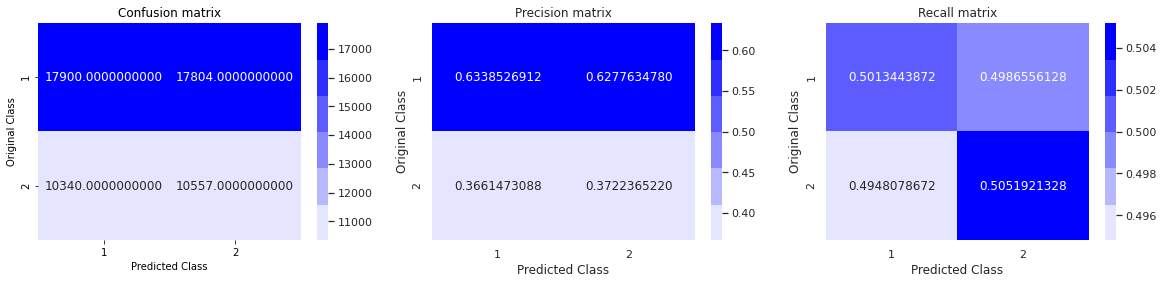

In [67]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

cv_len = len(y_cv_org)
predicted_y = np.zeros((cv_len,2))

for i in range(cv_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on CV Data using Random Model",log_loss(y_cv_org, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_cv_org, predicted_y)

<h4> Observations :- </h4>

* In this case, the log loss that you arrive at with the random model = 0.88. Hence even though log-loss as a metric can lie between 0 and infinity, for our given problem on all the questions considered, the Log loss we obtain is 0.88, and hence any smart model that we build should have a log-loss value which is significantly lesser than 0.88.
* Log- loss for a decent model should lie between 0 and 0.88. Thus if you get a log-loss value > 0.88, you can infer that the model you obtained is even worse than a dumb model. 
* Confusion Matrix :- Instead of class labels 0 & 1, we have 1 & 2 as the class labels:- Here you'll realise that your accuracy is approximately 50.27%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 63.38% of them actually belong to class 1 and 36.61% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, only 37.22% actually belong to class 2 and 62.77% of them belong to class 1. This distribution in Precision Matrix is not 50% each because in reality you have more points belonging to class 1 as compared to class 2 and because of this, you tend to have higher precision for Class 1 and lower precision for class 2. {The Diagonal values here are the Precision values for Class 1 and Class 2}

* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 50.13% of them belonging to class 1 and 49.86% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 49.48% of those points have been predicted by the random model to belong to class 1 and 50.51% to belong to class 2. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 1 and the Recall values for class 2. 


<h2> 4.2.4 Logistic Regression with Hyperparameter Tuning </h2>

<h4> Q. Why is Logistic Regression the right type of model for this problem? </h4> 

* Note that we have more than 218 Dimensions for this dataset (fairly high dimensional) and the models like Logistic Regression work very well when you have very high dimensional data.
* Note that here we are implementing Logistic Regression using an SGD Classifier with log loss and using L2 Regularizer. 
* Also when we try to fit the classifier on the Training data we also try to caliberate the scores because remember that our loss function is log-loss, and we know that whenever you have log-loss you should caliberate your models.

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

#First we ensure that all the nan values across our datasets are replaced by 0
train_data = train_data.fillna(0)
cv_data = cv_data.fillna(0)
test_data = test_data.fillna(0)

#Standardizing our data to be used for our Linear Models
scaler = StandardScaler()
train_data_std = scaler.fit_transform(train_data)
cv_data_std = scaler.transform(cv_data)
test_data_std = scaler.transform(test_data)

For values of alpha =  1e-05 The log loss is: 0.4884512761010729
For values of alpha =  0.0001 The log loss is: 0.4827274084501254
For values of alpha =  0.001 The log loss is: 0.4794610381689876
For values of alpha =  0.01 The log loss is: 0.4843116139227527
For values of alpha =  0.1 The log loss is: 0.5037711569667616
For values of alpha =  1 The log loss is: 0.5366445192207961
For values of alpha =  10 The log loss is: 0.5659315733513081


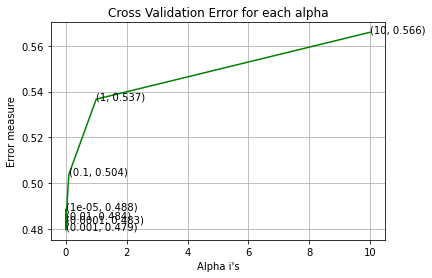

For values of best alpha =  0.001 The train log loss is: 0.42092737168495886
For values of best alpha =  0.001 The cv log loss is: 0.4794610381689876
For values of best alpha =  0.001 The test log loss is: 1.7492324940380122
Total number of data points : 56601


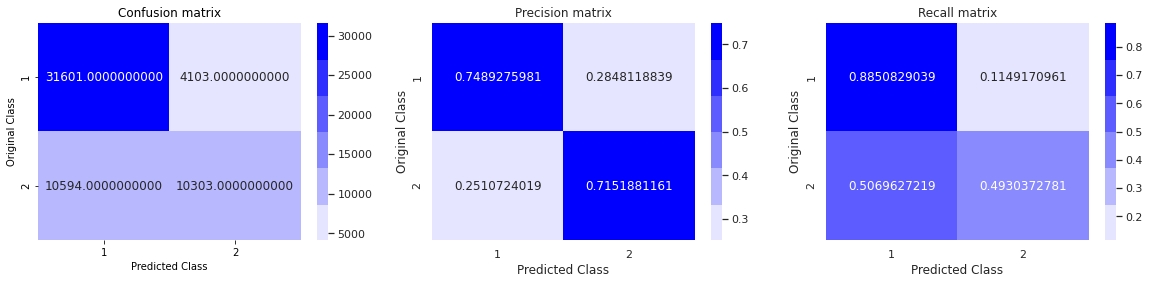

Time taken to run this cell : 0:03:51.935741


In [65]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

import datetime 
from datetime import datetime

start = datetime.now()

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_data_std, y_train2_org)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data_std, y_train2_org)
    
    predict_y = sig_clf.predict_proba(cv_data_std)
    log_error_array.append(log_loss(y_cv_org, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv_org, predict_y, labels=clf.classes_, 
                                                          eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_data_std, y_train2_org)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data_std, y_train2_org)

predict_y = sig_clf.predict_proba(train_data_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                                  log_loss(y_train2_org, predict_y, labels=clf.classes_, eps=1e-15))

predict_y_cv = sig_clf.predict_proba(cv_data_std)
print('For values of best alpha = ', alpha[best_alpha], "The cv log loss is:",log_loss(y_cv_org, predict_y_cv, 
                                    labels=clf.classes_, eps=1e-15))

predict_y_test = sig_clf.predict_proba(test_data_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_org, predict_y_test, 
                                    labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y_cv,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_org, predicted_y)

print("Time taken to run this cell :", datetime.now() - start)

<h4> Observations :- </h4> 

* In the log loss values that you obtained, since the values are not at all close to each other for Train and Test, we can say that our model is massively overfitting. (Infact the values of our Test loss are far far worse than the log-loss value obtained for a random model, which was 0.88).
* We could have said that the model was underfitting if  the Train,CV and Test log-loss values were approximately same as each other and had we trained a more complex model such as GBDT and this complex model gave a log-loss value of 0.30 or 0.40. (Since Logistic Regression is a very simple linear classifier it has a much higher chance of underfitting).
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (31601 + 10303)/56601 ie  74.03%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 74.89% of them actually belong to class 1 and 25.10% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 28.48% of the points belong to class 1 and 71.51% of the points actually belong to class 2. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 88.50% of them belonging to class 1 and 11.49% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 50.69% of those points have been predicted by the  model to belong to class 1 and 49.30% to belong to class 2. {This class 2 Value of Recall is the major cause of concern in this case}. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 1 and the Recall values for class 2. 

<h2> 4.2.5 Linear SVM with Hyperparameter Tuning </h2>

<h4> Note :- </h4>

* Here also, in the case of Linear SVM we have 1 Hyperparameter called alpha and you take the regularizer to be L1 Regularizer. Except this, everything else is the same.

For values of alpha =  1e-05 The log loss is: 0.4923673263818538
For values of alpha =  0.0001 The log loss is: 0.48551360640885455
For values of alpha =  0.001 The log loss is: 0.48471472311157343
For values of alpha =  0.01 The log loss is: 0.49673231828080167
For values of alpha =  0.1 The log loss is: 0.5720611902819617
For values of alpha =  1 The log loss is: 0.6585276898641849
For values of alpha =  10 The log loss is: 0.6585276898641849


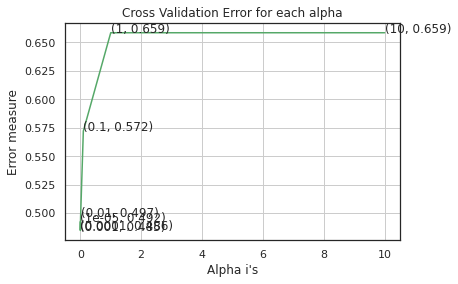

For values of best alpha =  0.001 The train log loss is: 0.42495516738576516
For values of best alpha =  0.001 The CV log loss is: 0.48471472311157343
For values of best alpha =  0.001 The test log loss is: 1.7701731821952311
Total number of data points : 56601


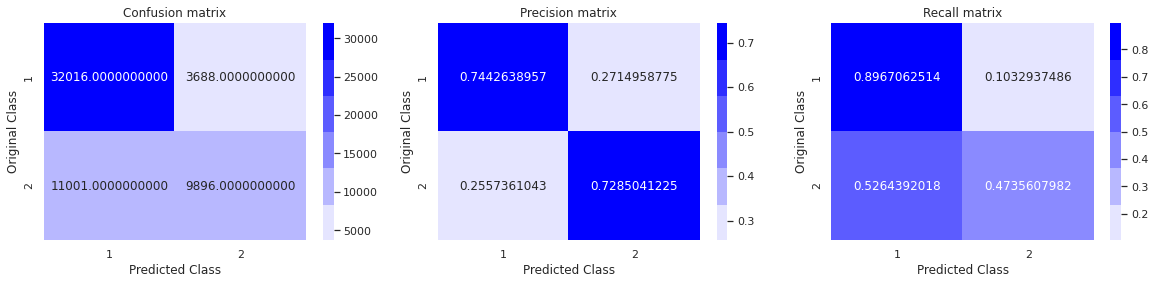

Time taken to run this cell : 0:07:55.805573


In [98]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

import datetime
from datetime import datetime
start = datetime.now()

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_data_std, y_train2_org)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data_std, y_train2_org)
    
    predict_y = sig_clf.predict_proba(cv_data_std)
    log_error_array.append(log_loss(y_cv_org, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv_org, predict_y, labels=clf.classes_,
                                                                   eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')

for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_data_std, y_train2_org)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data_std, y_train2_org)

predict_y = sig_clf.predict_proba(train_data_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train2_org, predict_y, 
                                        labels=clf.classes_, eps=1e-15))
predict_y_cv = sig_clf.predict_proba(cv_data_std)
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_loss(y_cv_org, predict_y_cv, 
                                        labels=clf.classes_, eps=1e-15))
predict_y_test = sig_clf.predict_proba(test_data_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_org, predict_y_test, 
                                        labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y_cv,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_org, predicted_y)

print("Time taken to run this cell :", datetime.now() - start)

<h4> Observations :- </h4>

* Best value of alpha for Linear SVM :- 0.001 (log-loss =0.484) and here you get a Test loss of 1.770. (which means that we are massively overfitting).
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (32016 + 9896)/56601 ie  74.04%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 74.42% of them actually belong to class 1 and 25.57% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 72.85% actually belong to class 2 and 27.14% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 89.67% of them belonging to class 1 and 10.32% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 52.64% of those points have been predicted by the model to belong to class 1 and 47.35% to belong to class 2. {Just as we saw for Logistic Regression, This class 2 Value of Recall is the major cause of concern in this case}. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 1 and the Recall values for class 2. 

<h2> 4.2.6 XGBoost</h2> 

<h2> 4.2.6.1 XGBoost :- Without any Hyperparameter Tuning </h2> 

<h4> Note :- </h4>

* If you had thousands of dimensions, training a Decision Tree based model would not have been the Best idea, but 218 is neither very high and neither very low dimensionality.
* So next we try with GBDT, and if this model is able to provide a much better log-loss value, we can conclude that
  our simple Linear Models are suffering from a Bias Problem, which can only be fixed by more complex models.

In [102]:
start = datetime.now()

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(train_data_std, label=y_train2_org.apply(pd.to_numeric,errors='coerce'))
d_cv = xgb.DMatrix(cv_data_std, label=y_cv_org.apply(pd.to_numeric,errors='coerce'))

watchlist = [(d_train, 'train'), (d_cv, 'valid')]

#log-loss is the evaluation metric being used to exit the procedure to improve the model test log-loss metric
#and we will stop after the same hasn't improved for 20 iterations. 

bst = xgb.train(params, d_train, 8000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(train_data_std, y_train2_org.apply(pd.to_numeric,errors='coerce'))
predict_y = bst.predict(d_cv)
print("The CV log loss is:",log_loss(y_cv_org, predict_y, labels=clf.classes_, eps=1e-15))

print("Time taken to run this cell :", datetime.now() - start)

[0]	train-logloss:0.68513	valid-logloss:0.68631
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61929	valid-logloss:0.62994
[20]	train-logloss:0.57090	valid-logloss:0.58931
[30]	train-logloss:0.53440	valid-logloss:0.55909
[40]	train-logloss:0.50675	valid-logloss:0.53674
[50]	train-logloss:0.48494	valid-logloss:0.51927
[60]	train-logloss:0.46762	valid-logloss:0.50555
[70]	train-logloss:0.45385	valid-logloss:0.49483
[80]	train-logloss:0.44280	valid-logloss:0.48632
[90]	train-logloss:0.43382	valid-logloss:0.47956
[100]	train-logloss:0.42629	valid-logloss:0.47382
[110]	train-logloss:0.41993	valid-logloss:0.46882
[120]	train-logloss:0.41457	valid-logloss:0.46459
[130]	train-logloss:0.41008	valid-logloss:0.46109
[140]	train-logloss:0.40617	valid-logloss:0.45788
[150]	train-logloss:0.40282	valid-logloss:0.45537
[160]	train-logloss:0.40005	valid-logloss:0.45308
[170]	trai

Total number of data points : 56601


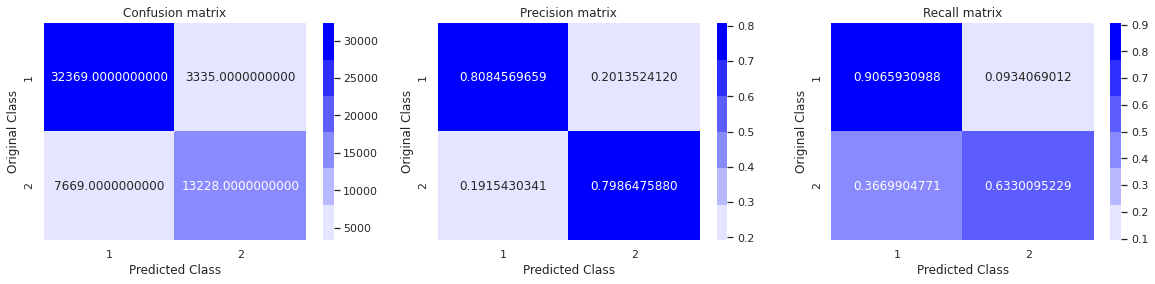

In [103]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_org, predicted_y)

<h4> Observations :- </h4>

* Best value of CV log-loss that we obtained :- 0.378.
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (32369 + 13228)/56601 ie  80.55%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 80.84% of them actually belong to class 1 and 19.15% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 79.86% actually belong to class 2 and 20.13% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 90.65% of them belonging to class 1 and 9.34% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 36.69% of those points have been predicted by the model to belong to class 1 and 63.30% to belong to class 2. We see here that the value of Recall for class 2 has improved significantly.

<h2> 4.2.6.2 XGBoost :- Hyperparameter Tuning </h2> 

Here we carry out Hyperparameter Tuning using Random Search with 3-fold Cross Validation to obtain the best possible Values of the Hyperparameter.

In [67]:
#Following blog was used as a reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

import xgboost as xgb
from datetime import datetime
import time 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

start = datetime.now()

#A parameter grid for XGBoost
params = {
        'eta' : [0.05,0.1,0.3],
        'min_child_weight': [5,6,7,8,9,10],
        'gamma': [0,0.10,0.20,0.50, 0.75],
        'subsample': [0.5,0.6, 0.7, 0.8,0.9],
        'colsample_bytree': [0.5, 0.6, 0.7,0.8,0.9],
        'max_depth': [3,4, 5, 6, 7, 8,9,10],
        'n_estimators' : [1000,5000]
        }


xgb = xgb.XGBClassifier(objective='binary:logistic', silent=False, verbose=10, n_jobs=-1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, scoring='neg_log_loss',
                                   n_jobs=-1, cv=3, verbose=10, random_state=0)
random_search.fit(train_data_std,y_train2_org)

print('\n Best hyperparameters:')
print(random_search.best_params_)

#Best cross validation log loss obtained from hyperparameter tuning
print("Best log loss obtained on Cross Validation data using hyperparameter tuning: ",random_search.best_score_)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 56.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 107.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 218.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 306.7min
[Parallel(n_jobs=-1)]: Done  53 out of  90 | elapsed: 552.8min remaining: 385.9min
[Parallel(n_jobs=-1)]: Done  63 out of  90 | elapsed: 600.2min remaining: 257.2min
[Parallel(n_jobs=-1)]: Done  73 out of  90 | elapsed: 825.4min remaining: 192.2min
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed: 949.5min remaining: 80.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 1086.9min finished



 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 10, 'gamma': 0.5, 'eta': 0.05, 'colsample_bytree': 0.5}
Best log loss obtained on Cross Validation data using hyperparameter tuning:  -0.3238339072361301
Time taken to run this cell : 19:55:44.796745


<h2> 4.2.6.3 XGBoost :- With Hyperparameter Tuning </h2> 

In [66]:
start = datetime.now()

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 10
params['subsample'] = 0.6
params['gamma'] = 0.5
params['colsample_bytree'] = 0.5
params['min_child_weight'] = 6
params['n_estimators'] = 1000


d_train = xgb.DMatrix(train_data_std , label=y_train2_org.apply(pd.to_numeric, errors='coerce'))
d_cv = xgb.DMatrix(cv_data_std, label=y_cv_org.apply(pd.to_numeric,errors='coerce'))

watchlist = [(d_train, 'train'), (d_cv, 'valid')]

bst = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(train_data_std,y_train2_org.apply(pd.to_numeric,errors='coerce'))
predict_y = bst.predict(d_cv)
print("The CV log loss is:",log_loss(y_cv_org, predict_y, labels=clf.classes_, eps=1e-15))

print("Time taken to run this cell :", datetime.now() - start)

[18:30:51] WARNING: /workspace/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.67391	valid-logloss:0.67464
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.51976	valid-logloss:0.54846
[20]	train-logloss:0.44299	valid-logloss:0.48736
[30]	train-logloss:0.39871	valid-logloss:0.45516
[40]	train-logloss:0.36961	valid-logloss:0.43413
[50]	train-logloss:0.35049	valid-logloss:0.42283
[60]	train-logloss:0.33731	valid-logloss:0.41585
[70]	train-logloss:0.32686	valid-logloss:0.41000
[80]	train-logloss:0.31835	valid-logloss:0.40636
[90]	train-logloss:0.31180	valid-logloss:0.40286
[100]	train-logloss:

Total number of data points : 56601


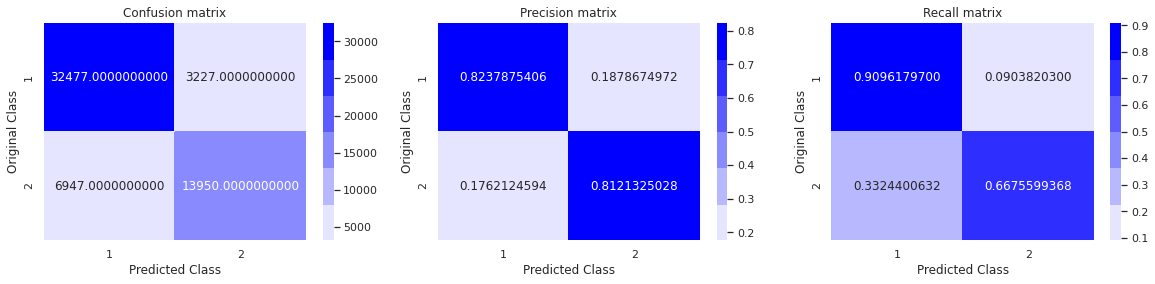

In [67]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_org, predicted_y)

<h4> Observations :- </h4>

* The very fact is that GBDT log loss is significantly lower than your linear models (which can have a bias problem) or an Underfitting Problem. Here you will note that both Training and CV losses are not close to each other at all, and hence we know that GBDT is massively overfitting. (GBDTs overfit very easily but they underfit on very rare occasions only).Though note that our recall values have improved in this case.
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (32477 + 13950)/56601 ie  82.02%, which is better than the value obtained without any Hyperparameter Tuning.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 82.37% of them actually belong to class 1 and 17.62% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 81.21% actually belong to class 2 and 18.78% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 90.96% of them belonging to class 1 and 9.03% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 33.24% of those points have been predicted by the model to belong to class 1 and 66.75% to belong to class 2.

# 5. Implementation of TFIDF Featurization :-

<h2> 5.1 Data Preparation </h2> 

In [62]:
# avoid decoding problems
df1 = pd.read_csv("train.csv")
df1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [63]:
#Stratify tries to ensure that when you are splitting the data into Train and Test the proportion of our class 
#labels across the obtained datasets remain the same. 

y_true_tfidf = df1['is_duplicate']

#Splitting the dataset into Train and Test :- (X_train and y_train are temporary datasets)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df1,y_true_tfidf, 
                                                           test_size=0.30, random_state=42,stratify=y_true_tfidf)

#Splitting the dataset into Train and CV :- (X_train and y_train are temporary datasets & X_train2 and y_train2
#are our final Train data components)
X_train2_tfidf, X_cv_tfidf, y_train2_tfidf, y_cv_tfidf = train_test_split(X_train_tfidf,y_train_tfidf,
                                                         test_size=0.20, random_state=42,stratify=y_train_tfidf)

In [64]:
# avoid decoding problems

X_train2_tfidf['question1'] = X_train2_tfidf['question1'].apply(lambda x: str(x))
X_train2_tfidf['question2'] = X_train2_tfidf['question2'].apply(lambda x: str(x))

X_cv_tfidf['question1'] = X_cv_tfidf['question1'].apply(lambda x: str(x))
X_cv_tfidf['question2'] = X_cv_tfidf['question2'].apply(lambda x: str(x))

X_test_tfidf['question1'] = X_test_tfidf['question1'].apply(lambda x: str(x))
X_test_tfidf['question2'] = X_test_tfidf['question2'].apply(lambda x: str(x))

In [65]:
from scipy.sparse import hstack

#We will consider both unigrams as well as bigrams and we only consider the Top 20K features.
tfidf2 = TfidfVectorizer(lowercase=True,ngram_range=(1,2),max_features=20000)

q1_tfidf_train = tfidf2.fit_transform(X_train2_tfidf['question1'])
q2_tfidf_train = tfidf2.fit_transform(X_train2_tfidf['question2'])
numeric_db_train = X_train2_tfidf.drop(['question1','question2','is_duplicate'],axis=1)
required_data_train = hstack((numeric_db_train,q1_tfidf_train,q2_tfidf_train))

q1_tfidf_cv = tfidf2.transform(X_cv_tfidf['question1'])
q2_tfidf_cv = tfidf2.transform(X_cv_tfidf['question2'])
numeric_db_cv = X_cv_tfidf.drop(['question1','question2','is_duplicate'],axis=1)
required_data_cv = hstack((numeric_db_cv,q1_tfidf_cv,q2_tfidf_cv))

q1_tfidf_test = tfidf2.transform(X_test_tfidf['question1'])
q2_tfidf_test = tfidf2.transform(X_test_tfidf['question2'])
numeric_db_test = X_test_tfidf.drop(['question1','question2','is_duplicate'],axis=1)
required_data_test = hstack((numeric_db_test,q1_tfidf_test,q2_tfidf_test))

In [66]:
#Since we are taking all the 400K datapoints
required_data_cv.shape

(56601, 40003)

In [67]:
#df with only basic features
only_basic_train = basic_fe_df_train2.drop(['qid1','qid2','question1','question2'],axis=1)
only_basic_cv = basic_fe_df_cv.drop(['qid1','qid2','question1','question2'],axis=1)
only_basic_test = basic_fe_df_test.drop(['qid1','qid2','question1','question2'],axis=1)

#df with only advance features
only_advance_train = adv_fe_df_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
only_advance_cv = adv_fe_df_cv.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
only_advance_test = adv_fe_df_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [68]:
only_basic_train.head(2)

,id,is_duplicate,word_Common,word_Total,word_share,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2
0,191528,1,3.0,26.0,0.115385,1,1,44,100,8,18,2,0
1,1809,0,6.0,39.0,0.153846,1,1,117,81,25,17,2,0


In [69]:
only_advance_train.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,25773,0.076922,0.076922,0.000000,0.000000,0.038461,0.037037,0.0,0.0,1.0,26.5,25,26,21,20,0.032520
1,290531,0.499994,0.444440,0.666644,0.333328,0.499996,0.428568,0.0,0.0,2.0,13.0,66,62,50,53,0.289474


In [70]:
#combining all the dataframes to obtain the final df 
basic_adv_combined_train = only_basic_train.merge(only_advance_train, on='id',how='left')
numeric_basic_adv_train  = numeric_db_train.merge(basic_adv_combined_train, on='id',how='left')

basic_adv_combined_cv = only_basic_cv.merge(only_advance_cv, on='id',how='left')
numeric_basic_adv_cv  = numeric_db_cv.merge(basic_adv_combined_cv, on='id',how='left')

basic_adv_combined_test = only_basic_test.merge(only_advance_test, on='id',how='left')
numeric_basic_adv_test  = numeric_db_test.merge(basic_adv_combined_test, on='id',how='left')

In [71]:
all_features_train = numeric_basic_adv_train.drop(['id','qid1','qid2','is_duplicate'],axis=1)
final_tfidf_train = hstack((required_data_train,all_features_train))
sampled_tfidf_csr_train = final_tfidf_train.tocsr()

all_features_cv = numeric_basic_adv_cv.drop(['id','qid1','qid2','is_duplicate'],axis=1)
final_tfidf_cv = hstack((required_data_cv,all_features_cv))
sampled_tfidf_csr_cv = final_tfidf_cv.tocsr()

all_features_test = numeric_basic_adv_test.drop(['id','qid1','qid2','is_duplicate'],axis=1)
final_tfidf_test = hstack((required_data_test,all_features_test))
sampled_tfidf_csr_test = final_tfidf_test.tocsr()

In [72]:
#Shape of each of the Datasets obtained
print("Number of data points in train data :",sampled_tfidf_csr_train.shape)
print("Number of data points in CV data :",sampled_tfidf_csr_cv.shape)
print("Number of data points in test data :",sampled_tfidf_csr_test.shape)

Number of data points in train data : (226402, 40029)
Number of data points in CV data : (56601, 40029)
Number of data points in test data : (121287, 40029)


In [73]:
from collections import Counter

#Checking the class label distribution across both the Train as well as the Test Datasets

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train2_tfidf)
train_len = len(y_train2_tfidf)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test_tfidf)
test_len = len(y_test_tfidf)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308027314246341 Class 1:  0.36919726857536594
---------- Distribution of output variable in test data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


<h2> 5.1.1 Building a Random Model (Finding Worst-Case Log-Loss) </h2>

<h4> Note :- </h4>

* Before we build actual ML Models we build a random model.
* Given a random model, if we are able to compute the log-loss on this model, it tells you the worst case log-loss that is possible. (There can be nothing worse than a random model)  

Log loss on CV Data using Random Model 0.887650071902322


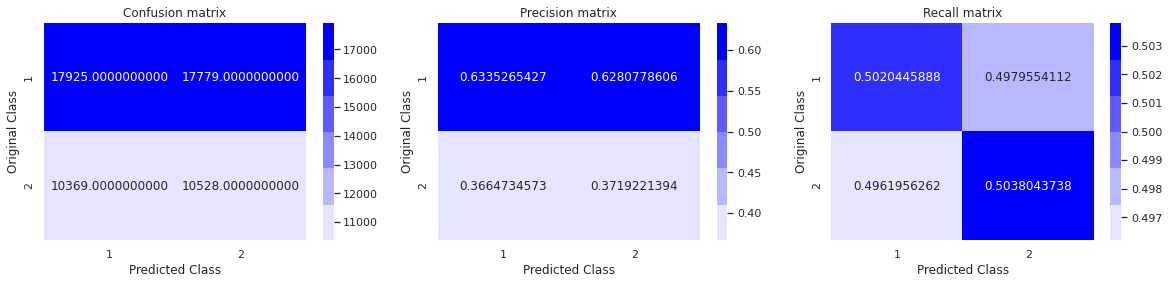

In [104]:
cv_len = len(y_cv_tfidf)
predicted_y = np.zeros((cv_len,2))

for i in range(cv_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on CV Data using Random Model",log_loss(y_cv_tfidf, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_cv_tfidf, predicted_y)

<h4> Observations :- </h4>

* In this case, the log loss that you arrive at with the random model = 0.88. Hence even though log-loss as a metric can lie between 0 and infinity, for our given problem considering all of our datapoints, the Log loss we obtain is 0.88, and hence any smart model that we build should have a log-loss value which is significantly lesser than 0.88.
* Log- loss for a decent model should lie between 0 and 0.88. Thus if you get a log-loss value > 0.88, you can infer that the model you obtained is even worse than a dumb model. 
* Confusion Matrix :- Instead of class labels 0 & 1, we have 1 & 2 as the class labels:- Here you'll realise that Accuracy - (17925 + 10528)/56601 => 50.26%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 63.35% of them actually belong to class 1 and 36.64% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, only 37.19% actually belong to class 2 and 62.80% of them belong to class 1. This distribution in Precision Matrix is not 50% each because in reality you have more points belonging to class 1 as compared to class 2 and because of this, you tend to have higher precision for Class 1 and lower precision for class 2. {The Diagonal values here are the Precision values for Class 1 and Class 2}

* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 50.20% of them belonging to class 1 and 49.79% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 49.61% of those points have been predicted by the random model to belong to class 1 and 50.38% to belong to class 2. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 1 and the Recall values for class 2. 

 <h2> 5.1.2 Logistic Regression with Hyperparameter Tuning </h2>

In [74]:
#Replacing all the nan values with xeroes across aur train,cv and test sparse matrices
sampled_tfidf_csr_train.data = np.nan_to_num(sampled_tfidf_csr_train.data, copy=False)
sampled_tfidf_csr_cv.data = np.nan_to_num(sampled_tfidf_csr_cv.data, copy=False)
sampled_tfidf_csr_test.data = np.nan_to_num(sampled_tfidf_csr_test.data, copy=False)

For values of alpha =  1e-05 The log loss is: 0.6585276899071809
For values of alpha =  0.0001 The log loss is: 0.6585276899071809
For values of alpha =  0.001 The log loss is: 0.6585276899071809
For values of alpha =  0.01 The log loss is: 0.6585276899071809
For values of alpha =  0.1 The log loss is: 0.6206250887380571
For values of alpha =  1 The log loss is: 0.5957511380661008
For values of alpha =  10 The log loss is: 0.6014168295301471


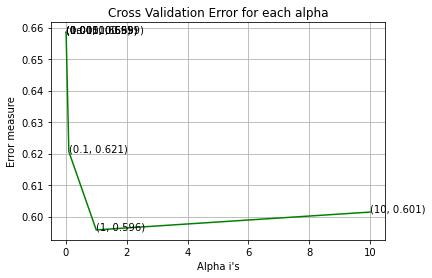

For values of best alpha =  1 The train log loss is: 0.5980133812317656
For values of best alpha =  1 The cv log loss is: 0.5957511380661008
For values of best alpha =  1 The test log loss is: 0.5971108930059688
Total number of data points : 56601


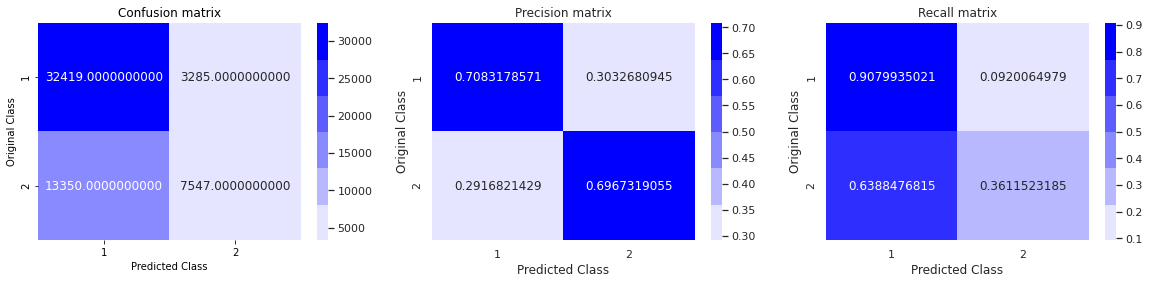

Time taken to run this cell : 0:48:22.677533


In [78]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

import datetime 
from datetime import datetime

start = datetime.now()

log_error_array=[]
for i in alpha:
    tfidf_clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    tfidf_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)
    
    sig_clf = CalibratedClassifierCV(tfidf_clf, method="sigmoid")
    sig_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)
    
    predict_y = sig_clf.predict_proba(sampled_tfidf_csr_cv)
    log_error_array.append(log_loss(y_cv_tfidf, predict_y, labels=tfidf_clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv_tfidf, predict_y, labels=tfidf_clf.classes_, 
                                                          eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')

for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
tfidf_clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
tfidf_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)

sig_clf = CalibratedClassifierCV(tfidf_clf, method="sigmoid")
sig_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)

predict_y_train = sig_clf.predict_proba(sampled_tfidf_csr_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                                  log_loss(y_train2_tfidf, predict_y_train, labels=tfidf_clf.classes_, eps=1e-15))

predict_y_cv = sig_clf.predict_proba(sampled_tfidf_csr_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cv log loss is:",log_loss(y_cv_tfidf, predict_y_cv, 
                                    labels=tfidf_clf.classes_, eps=1e-15))

predict_y_test = sig_clf.predict_proba(sampled_tfidf_csr_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y_test, 
                                    labels=tfidf_clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y_cv,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_tfidf, predicted_y)

print("Time taken to run this cell :", datetime.now() - start)

<h4> Observations :- </h4> 

* In the log loss values that you obtained, since the values are very close to each other for Train and Test, we can say that our model is not overfitting. But it could be underfitting because instead of 0.59, we need to think why is our log loss value not much smaller?
* We can say that it is underfitting if we train a more complex model such as GBDT. If this complex model gives a value of 0.30 or 0.40, then we can say that the Logistic Regression Model has an underfit problem. (Since Logistic Regression is a very simple linear classifier it has a much higher chance of underfitting).
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (32419 + 7547)/56601 ie  70.61%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 70.83% of them actually belong to class 1 and 29.16% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 69.67% actually belong to class 2 and 30.32% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 90.79% of them belonging to class 1 and 9.20% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 63.88% of those points have been predicted by the  model to belong to class 1 and 36.11% to belong to class 2. {Again these class 2 Recall Values are a major cause of concern }.

<h2> 5.1.3 Linear SVM with Hyperparameter Tuning </h2>

<h4> Note :- </h4>

* In the case of Linear SVM we have 1 Hyperparameter called alpha and you take the regularizer to be L1 Regularizer. Except this everything else is the same.

For values of alpha =  1e-05 The log loss is: 0.6585276899071809
For values of alpha =  0.0001 The log loss is: 0.6585276899071809
For values of alpha =  0.001 The log loss is: 0.6585276899071809
For values of alpha =  0.01 The log loss is: 0.6585276899071809
For values of alpha =  0.1 The log loss is: 0.6424870984821485
For values of alpha =  1 The log loss is: 0.5981364675643144
For values of alpha =  10 The log loss is: 0.5964240498046208


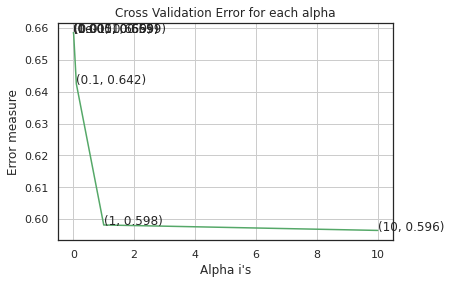

For values of best alpha =  10 The train log loss is: 0.5986430233649731
For values of best alpha =  10 The CV log loss is: 0.5964240498046208
For values of best alpha =  10 The test log loss is: 0.5977441105782189
Total number of data points : 56601


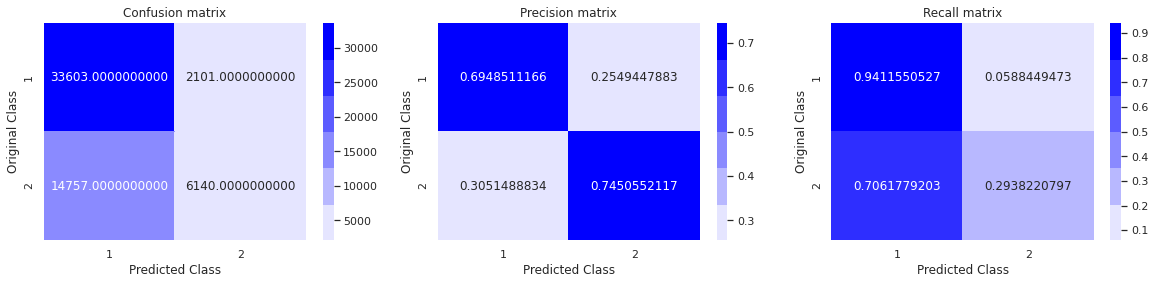

Time taken to run this cell : 0:51:07.647753


In [82]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

start = datetime.now()

log_error_array=[]

for i in alpha:
    tfidf_clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    tfidf_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)
    
    sig_clf = CalibratedClassifierCV(tfidf_clf, method="sigmoid")
    sig_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)
    
    predict_y = sig_clf.predict_proba(sampled_tfidf_csr_cv)
    log_error_array.append(log_loss(y_cv_tfidf, predict_y, labels=tfidf_clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv_tfidf, predict_y, 
                                                                labels=tfidf_clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')

for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
tfidf_clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
tfidf_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)

sig_clf = CalibratedClassifierCV(tfidf_clf, method="sigmoid")
sig_clf.fit(sampled_tfidf_csr_train, y_train2_tfidf)

predict_y_train = sig_clf.predict_proba(sampled_tfidf_csr_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train2_tfidf, 
                                                       predict_y_train, labels=tfidf_clf.classes_, eps=1e-15))

predict_y_cv = sig_clf.predict_proba(sampled_tfidf_csr_cv)
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_loss(y_cv_tfidf, predict_y_cv, 
                                                        labels=tfidf_clf.classes_, eps=1e-15))

predict_y_test = sig_clf.predict_proba(sampled_tfidf_csr_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf,predict_y_test, 
                                                        labels=tfidf_clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y_cv,axis=1)

print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_tfidf, predicted_y)

print("Time taken to run this cell :", datetime.now() - start)

<h4> Observations :- </h4>

* Best value of alpha for Linear SVM :- 10 (log-loss =0.596) and here you get a Test loss of 0.597. (which means that we are not overfitting).
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (33603 + 6140)/56601 ie  70.21%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 69.48% of them actually belong to class 1 and 30.51% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 74.50% actually belong to class 2 and 25.49% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 94.11% of them belonging to class 1 and 5.88% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 70.61% of those points have been predicted by the model to belong to class 1 and 29.38% to belong to class 2. {This class 2 Value of Recall is the major cause of concern in this case}.

<h2> 5.1.4 XGBoost</h2> 

<h2> 5.1.4.1 XGBoost :- Without any Hyperparameter Tuning </h2> 

<h4> Note :- </h4>

* If you had thousands of dimensions, training a Decision Tree based model would not have been the Best idea, but 218 is neither very high and neither very low dimensionality.
* So next we try with GBDT, and if this model is able to provide a much better log-loss value, we can conclude that
  our simple Linear Models are suffering from a Bias Problem, which can only be fixed by more complex models.

In [83]:
import datetime 
from datetime import datetime

start = datetime.now()

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(sampled_tfidf_csr_train, label=y_train2_tfidf.apply(pd.to_numeric, errors='coerce'))

d_cv = xgb.DMatrix(sampled_tfidf_csr_cv, label=y_cv_tfidf.apply(pd.to_numeric,errors='coerce'))

watchlist = [(d_train, 'train'), (d_cv, 'valid')]

bst = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(sampled_tfidf_csr_train, y_train2_tfidf)
predict_y = bst.predict(d_cv)
print("The CV log loss is:",log_loss(y_cv_tfidf, predict_y, labels=tfidf_clf.classes_, eps=1e-15))

print("Time taken to run this cell :", datetime.now() - start)

[0]	train-logloss:0.68846	valid-logloss:0.68837
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.65035	valid-logloss:0.64997
[20]	train-logloss:0.62357	valid-logloss:0.62301
[30]	train-logloss:0.60444	valid-logloss:0.60412
[40]	train-logloss:0.59083	valid-logloss:0.59098
[50]	train-logloss:0.58084	valid-logloss:0.58151
[60]	train-logloss:0.57275	valid-logloss:0.57425
[70]	train-logloss:0.56668	valid-logloss:0.56912
[80]	train-logloss:0.56179	valid-logloss:0.56524
[90]	train-logloss:0.55760	valid-logloss:0.56205
[100]	train-logloss:0.55431	valid-logloss:0.56010
[110]	train-logloss:0.55119	valid-logloss:0.55858
[120]	train-logloss:0.54848	valid-logloss:0.55739
[130]	train-logloss:0.54593	valid-logloss:0.55655
[140]	train-logloss:0.54355	valid-logloss:0.55572
[150]	train-logloss:0.54150	valid-logloss:0.55509
[160]	train-logloss:0.53961	valid-logloss:0.55441
[170]	trai

Total number of data points : 56601


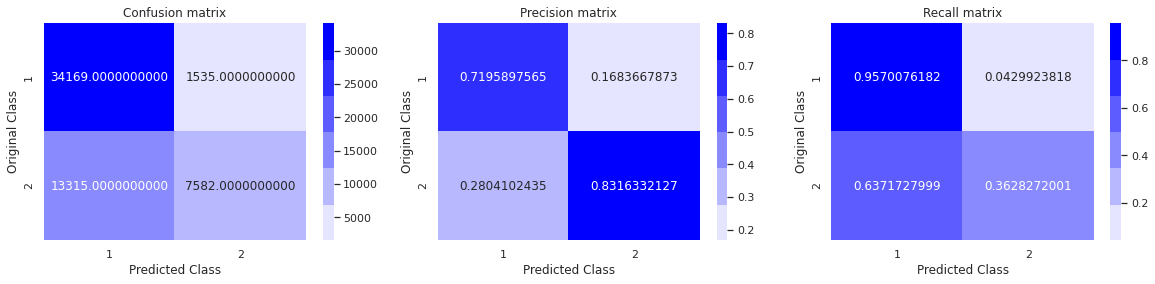

In [84]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_tfidf, predicted_y)

<h4> Observations :- </h4>

* Best value of CV log-loss that we obtained :- 0.549
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (34169 + 7582)/56601 ie  73.76%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 71.95% of them actually belong to class 1 and 28.04% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 83.16% actually belong to class 2 and 16.83% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 95.70% of them belonging to class 1 and 4.29% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 63.71% of those points have been predicted by the model to belong to class 1 and 36.28% to belong to class 2.

<h2> 5.1.4.2 XGBoost :- Hyperparameter Tuning </h2>

In [75]:
#This blog was used as a reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
import xgboost as xgb
from datetime import datetime
import time 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

start = datetime.now()

#A parameter grid for XGBoost
params = {
        'eta' : [0.05,0.1,0.3],
        'min_child_weight': [5,6,7,8,9,10],
        'gamma': [0,0.10,0.20,0.50, 0.75],
        'subsample': [0.5,0.6, 0.7, 0.8,0.9],
        'colsample_bytree': [0.5, 0.6, 0.7,0.8,0.9],
        'max_depth': [3,4, 5, 6, 7, 8,9,10],
        'n_estimators' : [1000,5000]
        }


xgb = xgb.XGBClassifier(objective='binary:logistic', silent=False, verbose=10, n_jobs=-1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, scoring='neg_log_loss',
                                   n_jobs=-1, cv=3, verbose=10, random_state=0)
random_search.fit(sampled_tfidf_csr_train, y_train2_tfidf)

print('\n Best hyperparameters:')
print(random_search.best_params_)

#Best cross validation log loss obtained from hyperparameter tuning
print("Best log loss obtained on Cross Validation data using hyperparameter tuning: ",random_search.best_score_)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 58.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 83.1min
[Parallel(n_jobs=-1)]: Done  53 out of  90 | elapsed: 155.5min remaining: 108.5min
[Parallel(n_jobs=-1)]: Done  63 out of  90 | elapsed: 163.6min remaining: 70.1min
[Parallel(n_jobs=-1)]: Done  73 out of  90 | elapsed: 232.2min remaining: 54.1min
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed: 262.0min remaining: 22.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 302.8min finished



 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 5000, 'min_child_weight': 5, 'max_depth': 9, 'gamma': 0.1, 'eta': 0.05, 'colsample_bytree': 0.7}
Best log loss obtained on Cross Validation data using hyperparameter tuning:  -0.42177527507977103
Time taken to run this cell : 7:53:19.679142


<h2> 5.1.4.3 XGBoost :- With Hyperparameter Tuning </h2>

In [79]:
start = datetime.now()

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 9
params['subsample'] = 0.6
params['gamma'] = 0.1
params['colsample_bytree'] = 0.7
params['min_child_weight'] = 5
params['n_estimators'] = 5000

d_train = xgb.DMatrix(sampled_tfidf_csr_train, label=y_train2_tfidf.apply(pd.to_numeric, errors='coerce'))

d_cv = xgb.DMatrix(sampled_tfidf_csr_cv, label=y_cv_tfidf.apply(pd.to_numeric,errors='coerce'))

watchlist = [(d_train, 'train'), (d_cv, 'valid')]

bst = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(sampled_tfidf_csr_train, y_train2_tfidf)
predict_y = bst.predict(d_cv)
print("The CV log loss is:",log_loss(y_cv_tfidf, predict_y, labels=tfidf_clf.classes_, eps=1e-15))

print("Time taken to run this cell :", datetime.now() - start)

[04:02:13] WARNING: /workspace/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.67912	valid-logloss:0.67892
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.59957	valid-logloss:0.60821
[20]	train-logloss:0.56026	valid-logloss:0.57743
[30]	train-logloss:0.53519	valid-logloss:0.55862
[40]	train-logloss:0.52168	valid-logloss:0.55062
[50]	train-logloss:0.51049	valid-logloss:0.54389
[60]	train-logloss:0.50308	valid-logloss:0.54167
[70]	train-logloss:0.49638	valid-logloss:0.53894
[80]	train-logloss:0.49100	valid-logloss:0.53883
[90]	train-logloss:0.48746	valid-logloss:0.53928
Stopping. Best itera

Total number of data points : 56601


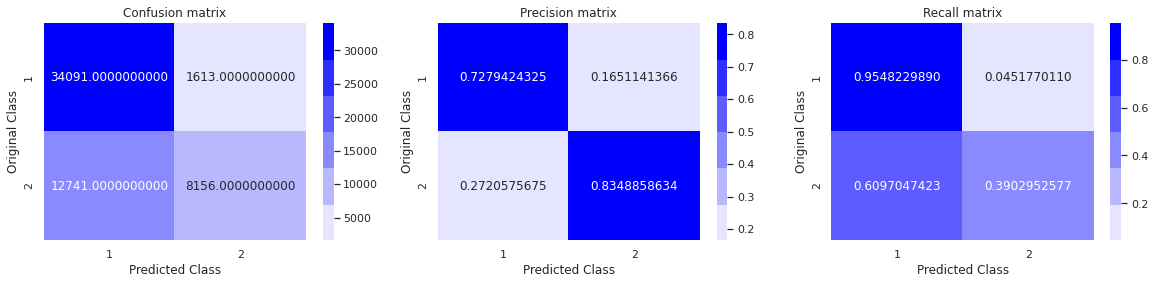

In [80]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_cv_tfidf, predicted_y)

<h4> Observations :- </h4>

* Best value of CV log-loss that we obtained :- 0.539.
* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (34091 + 8156)/56601 ie  74.64%, which is much better than the random model value.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 1, 72.79% of them actually belong to class 1 and 27.20% of them belong to class 2. Similarly of all the points that are predicted to belong to class 2, 83.48% actually belong to class 2 and 16.51% of them belong to class 1. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 1 your random model predicted 95.48% of them belonging to class 1 and 4.51% of them belonging to class 2. Similarly of all the points that originally belong to class 2, 60.97% of those points have been predicted by the model to belong to class 1 and 39.02% to belong to class 2. We again see that the Recall Value obtained for Class 2 is again the major cause for concern.

# 6. Conclusion :-

Quora is a popular Question & Answer Platform on the Internet with various people giving detailed answers to various questions. However, in order to improve the user experience on the Platform the developers need to ensure that similar worded questions are determined whether they are duplicates or not and the answers clubbed together are a single source so that this use of similar wording does not cause our answer sources to be spread throughout.Therefore the basic task at hand in this case was while we are given 2 questions we needed to determine whether they are duplicates of each other or not.

The constraints that we had over here were that the cost of misclassification is very high since if you decided to merge 2 questions determinig them to be duplicates (however they were not duplicates in reality), the irrelevant answers would be present for that particular question's link which can decrease the user satisfaction and that the user's trust on Quora would be lost. Again, we needed to remember that simply returning the output as 'duplicate' or 'non-duplicate' is not enough :- the interpretability is partially important ie we need to know the probability values for each of these 2 class labels - we can decide a threshold value based on our accuracy. Again, there were no strict latency constraints - our algorithm could have taken a few seconds to return its results. 

Hence we could easily conclude that it is a Binary Classification Task and we require the output of probability values for each of our class labels, and we knew that in such a scenario, log-loss is a very good performance metric, and hence it becomes our KPI. Another metric that we took into consideration are our Confusion Matrices - we can have a look at the Accuracy, Precision and Recall values with the help of this. 

Next we carried out our data split into Train and Test and since we did not have any Timestamp option available, we randomly split our data into Train and Test in 70-30 ratio. After this we carried out EDA followed by basic preprocessing steps on our dataset. Following this we did some feature engineering on the same :- first we generated some very basic features to try and see whether individually they were of any help in determining our class labels :- we were able to get an approximation when we constructed the histograms and violin plots for a few features to have a look at the overlap. This was followed by Feature Engineering with the help of advanced features such as common word count, fuzz ratio etc. 

Finally we obtained our dataframe with basic as well as advanced features, and two 96-dimensional vectors for each of our questions (when we carried out Featurization using TFIDF Word2Vec) and considering top 20K features for each when we carried out simple TFIDF Implementation. 

We began our ML Modelling by first constructing a random model in each scenario because we know that there is no upper limit on how bad log-loss value we can achieve, and hence we needed to find a threshold and create the dumbest model possible which gave us a log-loss value approximating to 0.88. Hence any logical model that we should have built must have resulted in a log-loss value that was considerably lower than this number. We followed this by the use of simple Linear Models such as Logistic Regression or Linear SVM which were average but the biggest issue with them was that they were returning extrememly poor Recall values for one of our classes. Hence we decided to carry out building more complex models such as GBDTs using XGBoost algorithm by Hyperparameter Tuning using Random Search, and finally the implementation of XGBoost on TFIDF Featurization using all the 400K + Datapoints after all the Hyperparameter Tuning returned us very satisfactory results across all the Performance Indicators. These KPIs across all models are summarized below :-

In [82]:
from prettytable import PrettyTable

print("Model Performance on TFIDF Word2Vec considering all 400K+ Datapoints")
print(" "*100)

x=PrettyTable()
x.field_names=["S No.","Model","Log Loss (CV/Test)","Accuracy","Pre (Cl-1)","Pre (Cl-2)","Re (Cl-1)",
               "Re (Cl-2)"]

x.add_row(["1","Random Model","0.884","50.27%","63.38%","37.22%","50.13%","50.51%"])
x.add_row(["2","Logistic Regression","1.749","74.03%","74.89%","71.51","88.50%","49.30%"])
x.add_row(["3","Linear SVM","1.770","74.04%","74.42%","72.85%","89.67%","47.35%"])
x.add_row(["4","XGBoost (W/O Tuning)","0.378","80.55%","80.84%","79.86%","90.65%","63.30%"])
x.add_row(["5","XGBoost (With Tuning)","0.360","82.02%","82.37%","81.21%","90.96%","66.75%"])

print(x)

print("="*100)

print("Model Performance on TFIDF considering all 400K+ Datapoints")
print(" "*100)

y=PrettyTable()
y.field_names=["S No.","Model","Log Loss (CV/Test)","Accuracy","Pre (Cl-1)","Pre (Cl-2)","Re (Cl-1)",
               "Re (Cl-2)"]

y.add_row(["1","Random Model","0.887","50.26%","63.35%","37.19%","50.20%","50.38%"])
y.add_row(["2","Logistic Regression","0.597","70.61%","70.83%","69.67%","90.79%","36.11%"])
y.add_row(["3","Linear SVM","0.597","70.21%","69.48%","74.50%","94.11%","29.38%"])
y.add_row(["4","XGBoost (W/O Tuning)","0.549","73.76%","71.95%","83.16%","95.70%","36.28%"])
y.add_row(["5","XGBoost (With Tuning)","0.539","74.64%","72.79%","83.48%","95.48%","39.02%"])

print(y)


Model Performance on TFIDF Word2Vec considering all 400K+ Datapoints
                                                                                                    
+-------+-----------------------+--------------------+----------+------------+------------+-----------+-----------+
| S No. |         Model         | Log Loss (CV/Test) | Accuracy | Pre (Cl-1) | Pre (Cl-2) | Re (Cl-1) | Re (Cl-2) |
+-------+-----------------------+--------------------+----------+------------+------------+-----------+-----------+
|   1   |      Random Model     |       0.884        |  50.27%  |   63.38%   |   37.22%   |   50.13%  |   50.51%  |
|   2   |  Logistic Regression  |       1.749        |  74.03%  |   74.89%   |   71.51    |   88.50%  |   49.30%  |
|   3   |       Linear SVM      |       1.770        |  74.04%  |   74.42%   |   72.85%   |   89.67%  |   47.35%  |
|   4   |  XGBoost (W/O Tuning) |       0.378        |  80.55%  |   80.84%   |   79.86%   |   90.65%  |   63.30%  |
|   5   | XGBoost 

<h4> Observations :- </h4>

* Considering all of these Models that we built and also considering all the KPI Values, we can conclude that using XGBoost after Hyperparameter Tuning and after using the TFIDF W2V Implementation, we are obtaining our Best Model for our problem at hand.
* Note that the biggest issue that we were facing across all of our models was the occurence of a poor Recall Value for Class 2. Even in this case, our XGBoost (With Hyperparameter Tuning & Implementing TFIDF Word2Vec) is performing comparatively better with a Class 2 Recall Value of 66.75%.